In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np

db_conn = {
     "user": "root",
     "password": "Dhyoon96!",
     "host": "127.0.0.1",
     "database": "side_proj_FCO"
 }

db_engine = "mysql+pymysql://%s:%s@%s/%s" % (
    db_conn["user"],
    db_conn["password"],
    db_conn["host"],
    db_conn["database"]
)

engine = create_engine(db_engine, echo=True)

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

mpl.rc('font', family = 'Malgun Gothic') # 한글 설정 (맑은 고딕)
mpl.rc('axes', unicode_minus = False) # 음수 부호 깨지는거 설정

import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [3]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [5]:
df_query = 'SELECT * FROM match_user'
df1 = pd.read_sql(df_query, con = engine);

2024-12-20 18:22:38,853 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2024-12-20 18:22:38,854 INFO sqlalchemy.engine.Engine [cached since 3.013s ago] {'table_schema': 'side_proj_fco', 'table_name': 'SELECT * FROM match_user'}
2024-12-20 18:22:38,858 INFO sqlalchemy.engine.Engine SELECT * FROM match_user
2024-12-20 18:22:38,860 INFO sqlalchemy.engine.Engine [raw sql] {}


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 27 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   match_id                          86 non-null     object 
 1   user_ouid                         86 non-null     object 
 2   user_nickname                     86 non-null     object 
 3   match_result                      86 non-null     object 
 4   match_endtype                     86 non-null     int64  
 5   match_possession                  86 non-null     int64  
 6   match_avg_rating                  86 non-null     float64
 7   match_total_dribble               86 non-null     int64  
 8   match_total_pass_try              86 non-null     int64  
 9   match_total_pass_suc              86 non-null     int64  
 10  match_total_shoot                 86 non-null     int64  
 11  match_total_shoot_eff             86 non-null     int64  
 12  match_tota

In [13]:
df1.describe()

match_endtype  match_possession  match_avg_rating  match_total_dribble  \
count      86.000000         86.000000         86.000000            86.000000   
mean        1.476744         51.790698          3.789729            10.930233   
std         0.502388         20.452594          0.410166             8.783394   
min         1.000000          0.000000          3.038890             0.000000   
25%         1.000000         43.250000          3.445830             3.250000   
50%         1.000000         53.000000          3.688885             9.500000   
75%         2.000000         62.500000          4.131943            16.750000   
max         2.000000        100.000000          4.755560            32.000000   

       match_total_pass_try  match_total_pass_suc  match_total_shoot  \
count             86.000000             86.000000          86.000000   
mean              15.244186             13.546512           1.383721   
std               11.715185             10.694316           1.617322   
min                0.000000              0.000000           0.000000   
25%                5.000000              4.000000           0.000000   
50%               13.000000             12.000000           1.000000   
75%               24.750000             21.000000           2.000000   
max               45.000000             42.000000          10.000000   

       match_total_shoot_eff  match_total_goal  attack_position_ratings  ...  \
count              86.000000         86.000000                86.000000  ...   
mean                1.011628          0.720930                 6.307442  ...   
std                 1.315019          0.978007                 0.839783  ...   
min                 0.000000          0.000000                 4.970000  ...   
25%                 0.000000          0.000000                 5.805000  ...   
50%                 1.000000          0.000000                 6.020000  ...   
75%                 2.000000          1.000000                 6.780000  ...   
max                 8.000000          3.000000                 8.440000  ...   

       match_total_pass_short_try  match_total_pass_short_suc  \
count                   86.000000                   86.000000   
mean                    10.581395                    9.965116   
std                      9.088409                    8.642505   
min                      0.000000                    0.000000   
25%                      2.000000                    2.000000   
50%                      9.000000                    8.000000   
75%                     16.000000                   15.000000   
max                     36.000000                   36.000000   

       match_total_pass_long_try  match_total_pass_long_suc  \
count                  86.000000                  86.000000   
mean                    0.593023                   0.290698   
std                     0.912371                   0.591435   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     0.000000                   0.000000   
75%                     1.000000                   0.000000   
max                     4.000000                   3.000000   

       match_total_pass_through_try  match_total_pass_through_suc  \
count                     86.000000                     86.000000   
mean                       3.453488                      2.930233   
std                        3.818398                      3.224139   
min                        0.000000                      0.000000   
25%                        1.000000                      0.000000   
50%                        2.000000                      2.000000   
75%                        5.000000                      4.000000   
max                       22.000000                     18.000000   

       match_total_shoot_outpenalty_try  match_total_shoot_outpenalty_suc  \
count                         86.000000               

In [14]:
df1['match_result'].value_counts()

match_result
승    45
패    41
Name: count, dtype: int64

In [15]:
df1['match_endtype'].value_counts() # 0 : 정상 종료, 1 : 몰수승, 2 : 몰수패

match_endtype
1    45
2    41
Name: count, dtype: int64

---

# 변수간 상관관계 및 VIF 확인

### 변수간 상관관계 분석 

In [11]:
df1_temp = df1.drop(columns = ['match_id', 'user_ouid', 'user_nickname', 'match_result'])

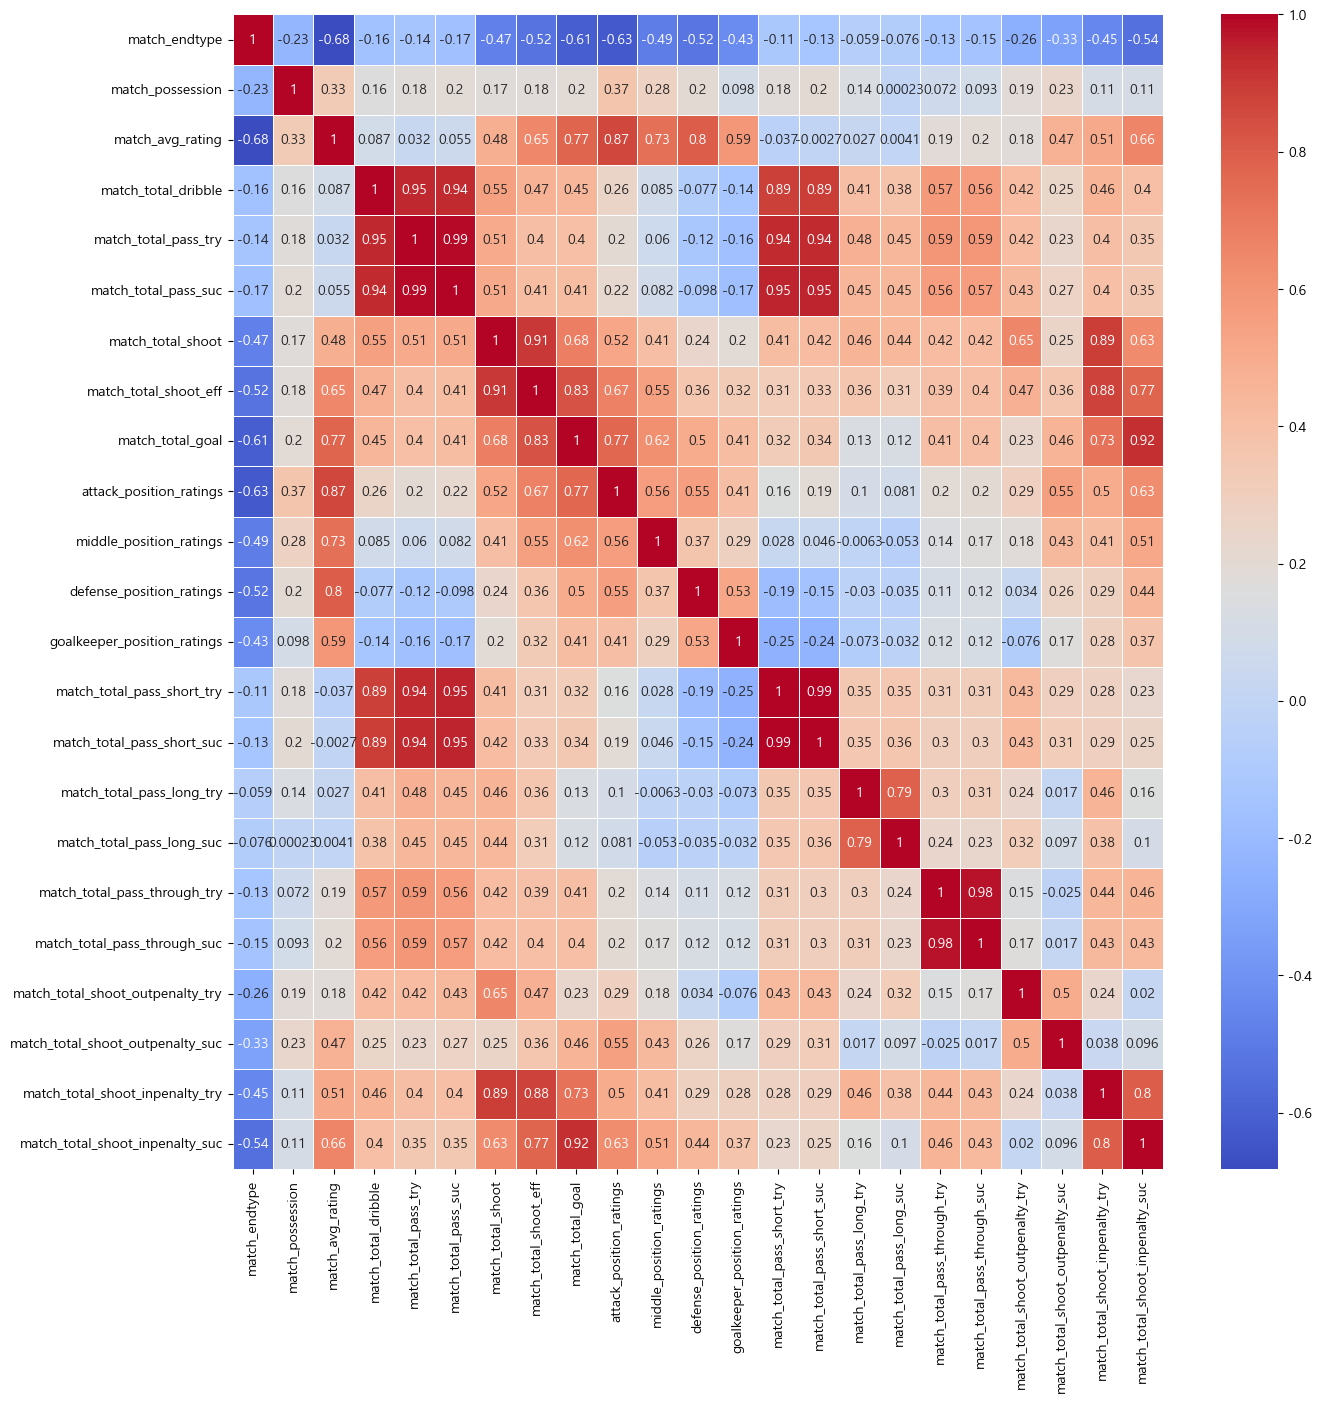

In [12]:
fig, ax = plt.subplots(figsize = (15, 15))
sns.heatmap(df1_temp.corr(), annot = True, linewidths = .5, cmap = 'coolwarm')
plt.show()

In [10]:
threshold = 0.9
corr_matrix = df1_temp.corr()

strong_corr_pairs = (
    corr_matrix
    .where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))    
    .stack()    
    .reset_index()  
)
strong_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
strong_corr_pairs = strong_corr_pairs[strong_corr_pairs['Correlation'] > threshold]

print(strong_corr_pairs)

                       Variable 1                       Variable 2  \
27               match_avg_rating          attack_position_ratings   
41            match_total_dribble             match_total_pass_try   
42            match_total_dribble             match_total_pass_suc   
60           match_total_pass_try             match_total_pass_suc   
68           match_total_pass_try       match_total_pass_short_try   
69           match_total_pass_try       match_total_pass_short_suc   
85           match_total_pass_suc       match_total_pass_short_try   
86           match_total_pass_suc       match_total_pass_short_suc   
95              match_total_shoot            match_total_shoot_eff   
109             match_total_shoot  match_total_shoot_inpenalty_try   
124         match_total_shoot_eff  match_total_shoot_inpenalty_try   
139              match_total_goal  match_total_shoot_inpenalty_suc   
186    match_total_pass_short_try       match_total_pass_short_suc   
216  match_total_pas

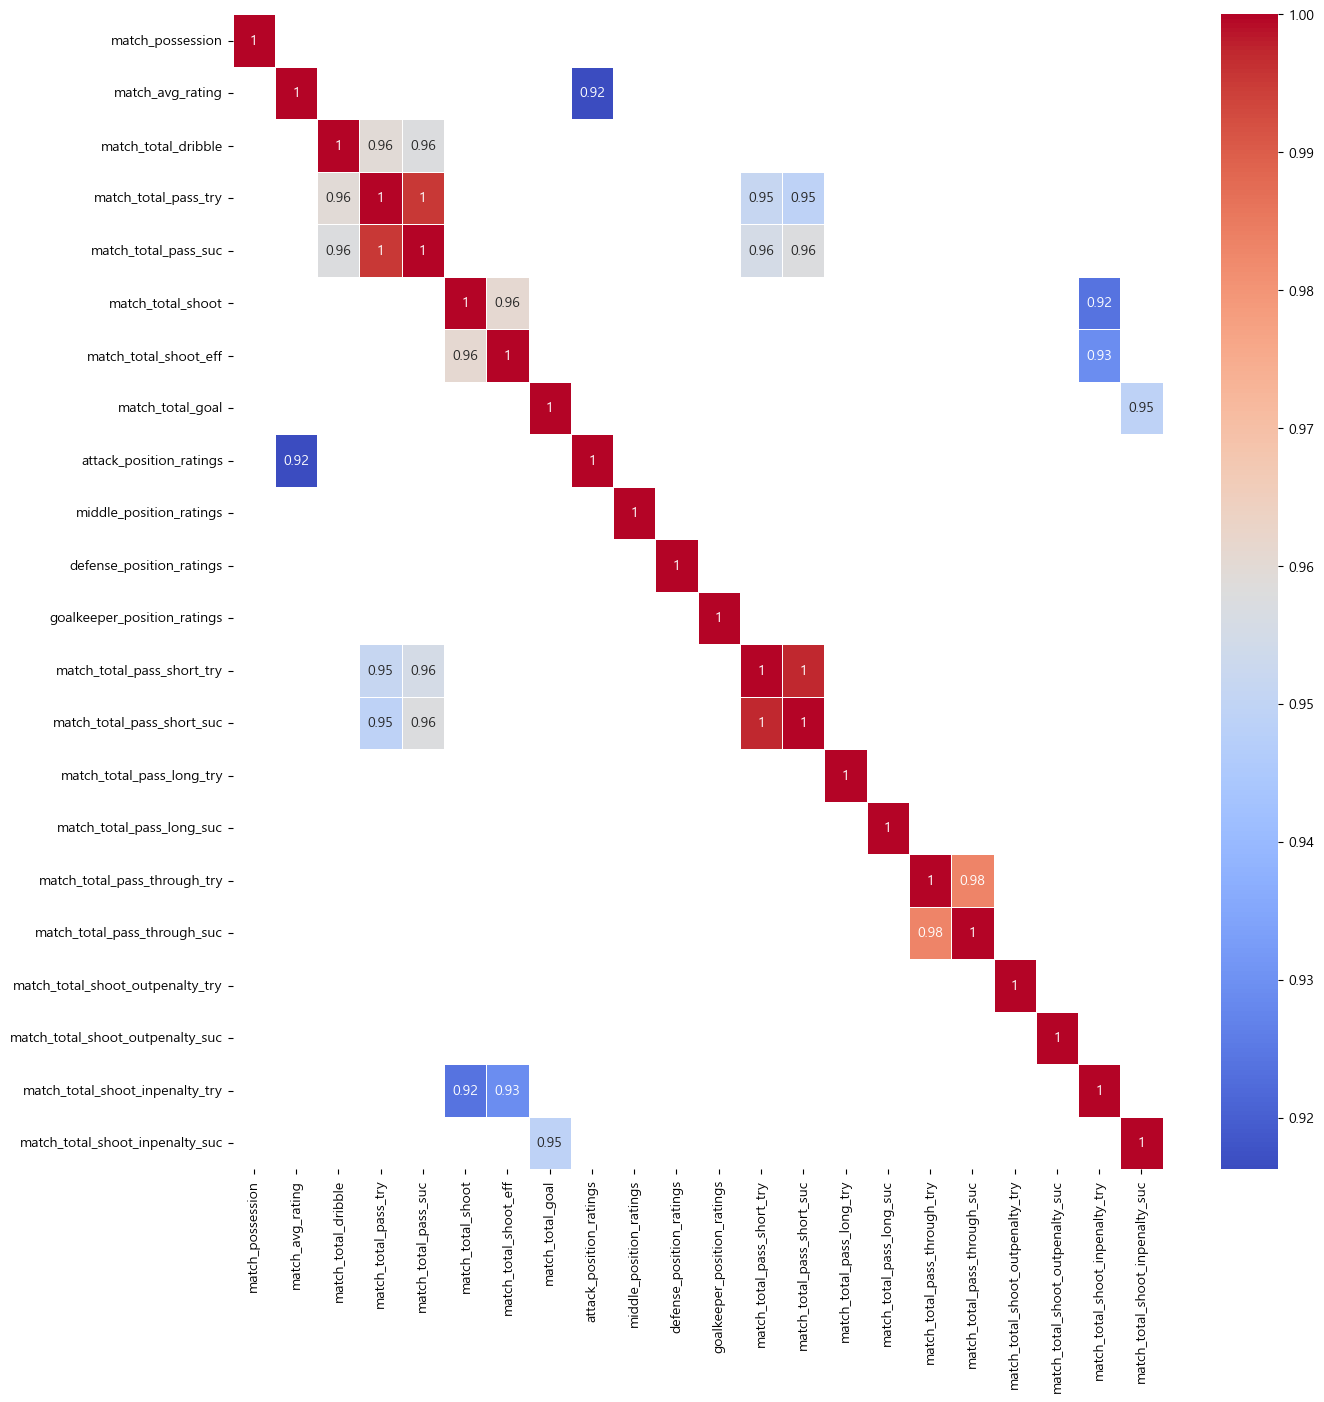

In [11]:
mask = np.abs(corr_matrix) <= threshold  

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, mask = mask, annot = True, linewidths = 0.5, cmap = 'coolwarm', ax = ax)
plt.show()

### 변수 제거 후 상관계수 및 VIF 확인

In [12]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Feature Removal Based on VIF Threshold
def calculate_vif_(X, thresh = 10):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped = True
    
    while dropped:
        dropped = False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(f"Dropping '{X[cols[variables]].columns[maxloc]}' at index {maxloc}")
            variables = np.delete(variables, maxloc)
            dropped = True

    if len(variables) == 0:
        print("All variables were removed. No remaining variables.")
        return pd.DataFrame() 

    print("Remaining variables:")
    print(X.columns[variables])
    return X[cols[variables]]

df2_temp = calculate_vif_(df1_temp)

# df2_temp = df1_temp.drop(columns = ['match_avg_rating', 
#                           'match_total_dribble', 'match_total_pass_try', 'match_total_pass_suc',
#                           'match_total_shoot', 'match_total_shoot_eff', 
#                           'match_total_pass_short_suc', 'match_total_pass_through_suc', 'match_total_pass_long_suc', 
#                           'match_total_shoot_outpenalty_suc', 'match_total_shoot_inpenalty_suc']
#                            + position_ratings_col)

Dropping 'match_avg_rating' at index 1
Dropping 'match_total_pass_suc' at index 3
Dropping 'match_total_shoot' at index 3
Dropping 'match_total_pass_short_try' at index 9
Dropping 'match_total_pass_try' at index 2
Dropping 'match_total_goal' at index 3
Dropping 'defense_position_ratings' at index 5
Dropping 'attack_position_ratings' at index 3
Dropping 'match_total_pass_through_try' at index 8
Dropping 'middle_position_ratings' at index 3
Dropping 'match_total_dribble' at index 1
Dropping 'match_total_shoot_eff' at index 1
Remaining variables:
Index(['match_possession', 'goalkeeper_position_ratings',
       'match_total_pass_short_suc', 'match_total_pass_long_try',
       'match_total_pass_long_suc', 'match_total_pass_through_suc',
       'match_total_shoot_outpenalty_try', 'match_total_shoot_outpenalty_suc',
       'match_total_shoot_inpenalty_try', 'match_total_shoot_inpenalty_suc'],
      dtype='object')


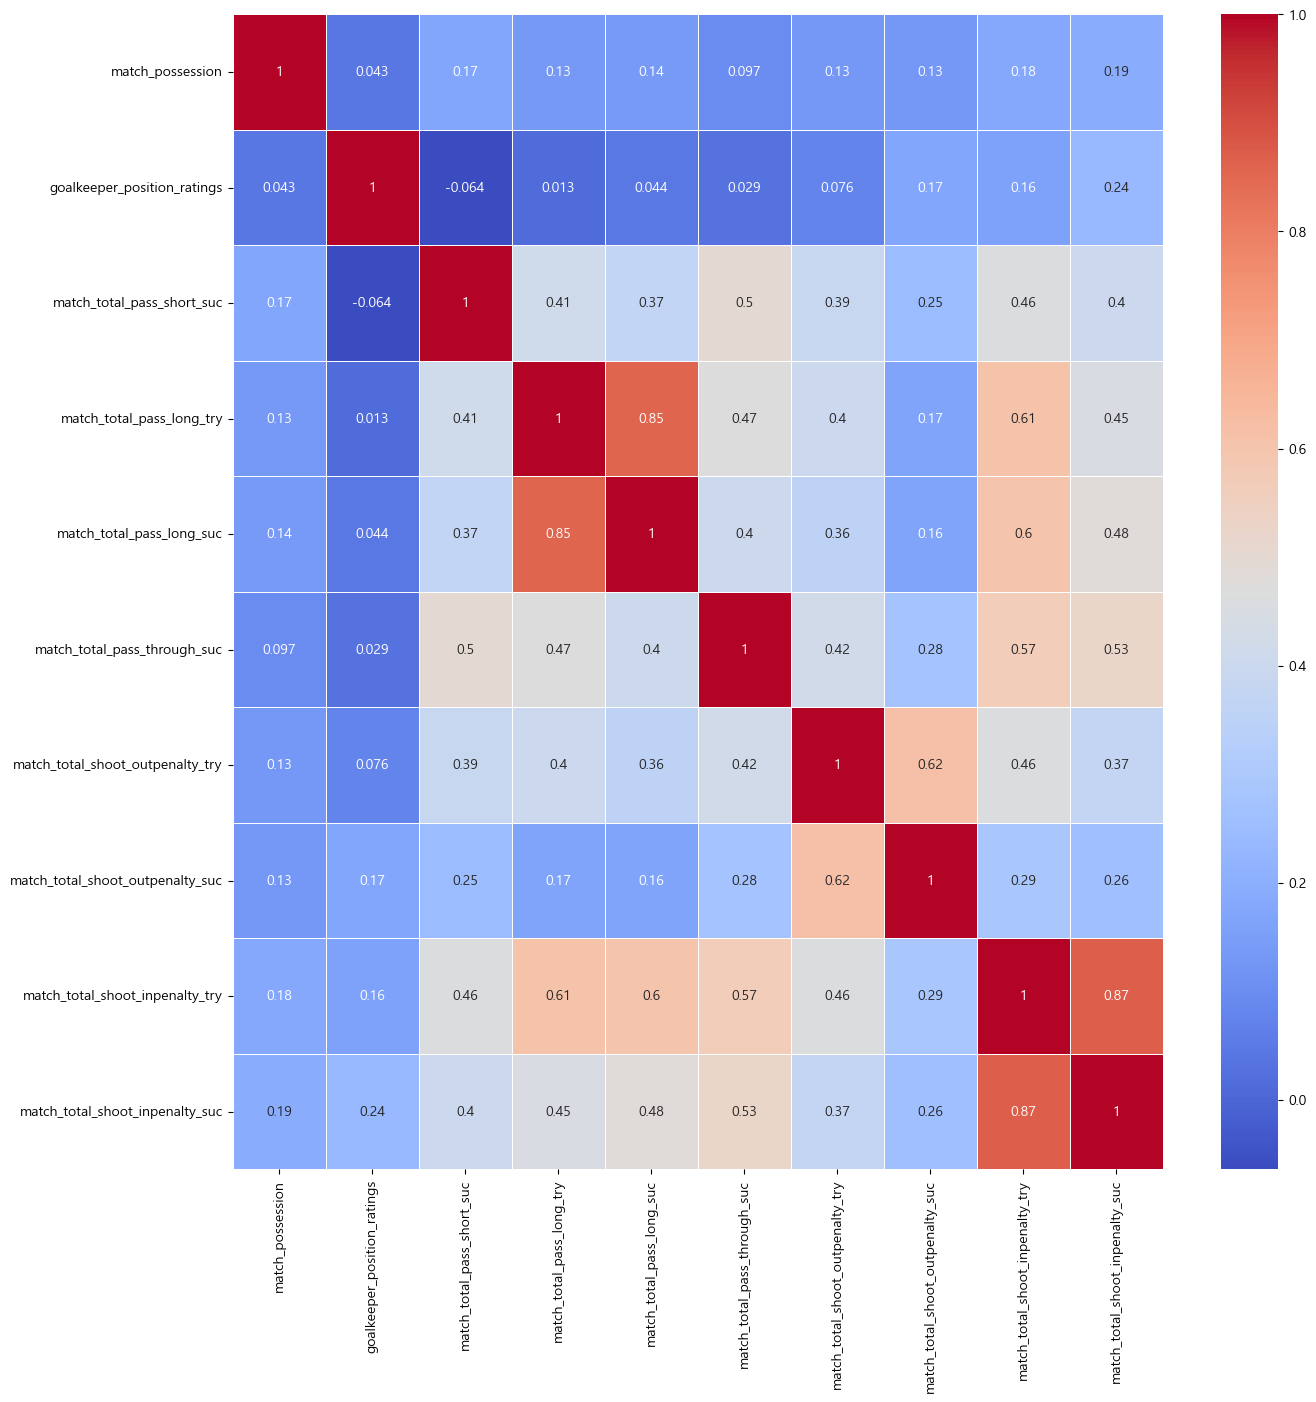

In [13]:
fig, ax = plt.subplots(figsize = (15, 15))
sns.heatmap(df2_temp.corr(), annot = True, linewidths = .5, cmap = 'coolwarm')
plt.show()

In [14]:
threshold = 0.7
corr_matrix = df2_temp.corr()
strong_corr_pairs = (
    corr_matrix
    .where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(bool))  
    .stack()   
    .reset_index()    
)
strong_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
strong_corr_pairs = strong_corr_pairs[strong_corr_pairs['Correlation'] > threshold]

print(strong_corr_pairs)

                         Variable 1                       Variable 2  \
24        match_total_pass_long_try        match_total_pass_long_suc   
44  match_total_shoot_inpenalty_try  match_total_shoot_inpenalty_suc   

    Correlation  
24     0.854859  
44     0.869187  


In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 출력 함수
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Variable"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    return vif

vif_data = calculate_vif(df2_temp)
vif_data

Variable       VIF
0                  match_possession  7.034584
1       goalkeeper_position_ratings  6.879765
2        match_total_pass_short_suc  3.141320
3         match_total_pass_long_try  6.446252
4         match_total_pass_long_suc  5.110694
5      match_total_pass_through_suc  3.051974
6  match_total_shoot_outpenalty_try  2.526497
7  match_total_shoot_outpenalty_suc  1.886712
8   match_total_shoot_inpenalty_try  8.039607
9   match_total_shoot_inpenalty_suc  5.792604

---

---

In [16]:
basic_col = ['match_possession', 
             'match_avg_rating', 
             'match_total_dribble', 
             'match_total_goal', 
             'match_total_shoot', 
             'match_total_pass_suc']

position_ratings_col = ['attack_position_ratings', 
                        'middle_position_ratings', 
                        'defense_position_ratings', 
                        'goalkeeper_position_ratings']

pass_col = ['match_total_pass_try', 
            'match_total_pass_suc',    
            'match_total_pass_short_try',
            'match_total_pass_short_suc', 
            'match_total_pass_long_try',
            'match_total_pass_long_suc', 
            'match_total_pass_through_try', 
            'match_total_pass_through_suc']

shoot_col = ['match_total_shoot', 
             'match_total_shoot_eff', 
             'match_total_shoot_outpenalty_try', 
             'match_total_shoot_outpenalty_suc', 
             'match_total_shoot_inpenalty_try', 
             'match_total_shoot_inpenalty_suc']

In [17]:
df3 = df1.copy()

df_win_query = "SELECT * FROM match_user WHERE match_result = '승'"
df3_win = pd.read_sql(df_win_query, con = engine)

df_lose_query = "SELECT * FROM match_user WHERE match_result = '패'"
df3_lose = pd.read_sql(df_lose_query, con = engine)

2024-12-19 19:37:27,899 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2024-12-19 19:37:27,899 INFO sqlalchemy.engine.Engine [cached since 2.865s ago] {'table_schema': 'side_proj_fco', 'table_name': "SELECT * FROM match_user WHERE match_result = '승'"}
2024-12-19 19:37:27,916 INFO sqlalchemy.engine.Engine SELECT * FROM match_user WHERE match_result = '승'
2024-12-19 19:37:27,916 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-12-19 19:37:27,976 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2024-12-19 19:37:27,976 INFO sqlalchemy.engine.Engine [cached since 2.928s ago] {'table_schema': 'side_proj_fco', 'table_name': "SELECT * FROM match_user WHERE match_result = '패'"}
2024-12-19 19:37:27,976 INFO sqlalchemy.engine.Engine SELECT * FROM match_user WHERE match_result = '패'
2024-12-19 19:37:27,9

In [18]:
df3_win

match_id                         user_ouid  \
0     67418a50fcfb86525b068dc9  c5bd2d238afff4775b5e6bc5c928e31c   
1     67418a525b7f6b04d21d13d4  a49aaacc626c90bca37e175eb31ec288   
2     67418a58060e19029147892c  0db87e3296072311b38a1c19fc243939   
3     67418a5b49725df11f881dad  48d376ea55efee991a7155369a1fa951   
4     67418a6ac076266384b39cb0  25773019db5c3fb18d2f71ecfd353a4c   
...                        ...                               ...   
1502  6763c3d05607d963bf647623  8303af29c024663b63a8fcf174bcc599   
1503  6763c3f5abdcd0e3a3a83cdc  5e3e24b6c98195e9a5755f383d47ddaf   
1504  6763c3fdfd61472df05a1055  46d3b4498e59e76c5049b1fe7481d67e   
1505  6763c40bbb39e78c6b3fceef  30734e68d7f64a598cc22c6988781394   
1506  6763c42e7ff8c705ed993e44  24039429eec39bd307e88a32c4cc9e95   

     user_nickname match_result  match_possession  match_avg_rating  \
0        SaddIerS3            승                70           4.08333   
1             A헤가오            승                59           4.17222   
2        LanderSSG            승                53           4.14444   
3           호날두lol            승                48           4.45556   
4             LA애플            승                54           4.10556   
...            ...          ...               ...               ...   
1502     120502ljj            승                58           3.65556   
1503          부산거미            승                69           4.24444   
1504      타겟형스트라이커            승                 7           3.66667   
1505       하핳핳핳핳핳하            승                90           5.02778   
1506        나우시카12            승                 0           3.66667   

      match_total_dribble  match_total_pass_try  match_total_pass_suc  \
0                      19                    19                    17   
1                      17                    32                    28   
2                      23                    32                    29   
3                      32                    44                    44   
4                      17                    20                    16   
...                   ...                   ...                   ...   
1502                    5                     5                     5   
1503                   13                    17                    16   
1504                    1                     0                     0   
1505                    8                    16                    15   
1506                    0                     0                     0   

      match_total_shoot  ...  match_total_pass_short_try  \
0                     4  ...                          12   
1                     4  ...                          26   
2                     1  ...                          24   
3                     7  ...                          40   
4                     1  ...                          12   
...                 ...  ...                         ...   
1502                  2  ...                           5   
1503                  1  ...                          13   
1504                  0  ...                           0   
1505                  1  ...                          14   
1506                  0  ...                           0   

      match_total_pass_short_suc  match_total_pass_long_try  \
0                             12                          1   
1                             23                          0   
2                             23                          2   
3                             40                          1   
4                             12                          4   
...                          ...                        ...   
1502                           5                          0   
1503                          13                          0   
1504                           0                          0   
1505                          14                          0   
1506                           0                          0  

In [19]:
df3_lose

match_id                         user_ouid  \
0     67418a563909e504f56f8222  623d56892e95056759904c52507a366a   
1     67418a5b49725df11f881dad  aa233a8979530bf9c68c70887af62fe5   
2     67418a5e50df1b077eba40ff  000b9119e3cc3c8889df346602ca0de8   
3     67418a6026241724d12a3e7e  382e7980d4c625c9d30e4be9cf50aecf   
4     67418a64f9e8d30e30e3cc4a  dcd1aae1a87b11c630ba8cfa281c8352   
...                        ...                               ...   
1326  6763c3d05607d963bf647623  69335e273ce00ef77e2aae4bff88edf9   
1327  6763c3e09e87e24337eb0b5a  6f7cc62aca64d952232a5ace61ac811c   
1328  6763c3fdfd61472df05a1055  1d4c352994a719a7e6df661523616c11   
1329  6763c40bbb39e78c6b3fceef  15c5a882df94f9f3e5f6471004c7a92c   
1330  6763c42e7ff8c705ed993e44  69335e273ce00ef77e2aae4bff88edf9   

     user_nickname match_result  match_possession  match_avg_rating  \
0            대북중1짱            패                47           3.76111   
1             헛똑똑이            패                52           3.23333   
2              후어유            패                17           4.10556   
3           불멸의발주먹            패                43           3.47222   
4               락견            패                61           3.80000   
...            ...          ...               ...               ...   
1326            어획            패                27           3.89444   
1327         커티스조슨            패                56           3.68889   
1328        강력한즐라탄            패               100           3.88333   
1329      닭다리도둑은없다            패                10           3.43889   
1330            어획            패               100           3.88333   

      match_total_dribble  match_total_pass_try  match_total_pass_suc  \
0                      21                    25                    23   
1                      18                    30                    25   
2                       2                     1                     1   
3                      24                    45                    40   
4                      21                    28                    27   
...                   ...                   ...                   ...   
1326                    1                     0                     0   
1327                    0                     1                     0   
1328                    2                     3                     2   
1329                    1                     2                     1   
1330                    1                     2                     2   

      match_total_shoot  ...  match_total_pass_short_try  \
0                     0  ...                          12   
1                     0  ...                          22   
2                     0  ...                           1   
3                     3  ...                          32   
4                     4  ...                          23   
...                 ...  ...                         ...   
1326                  0  ...                           0   
1327                  0  ...                           0   
1328                  0  ...                           1   
1329                  0  ...                           1   
1330                  0  ...                           1   

      match_total_pass_short_suc  match_total_pass_long_try  \
0                             12                          0   
1                             21                          2   
2                              1                          0   
3                             31                          2   
4                             22                          1   
...                          ...                        ...   
1326                           0                          0   
1327                           0                          1   
1328                           1                          0   
1329                           1                          0   
1330                           1                          1  

---

## Stat별 HIST

In [20]:
def col_hist_all(df, col_name) : 
    fig, ax = plt.subplots(ncols = len(col_name), 
                           figsize = (3.5 * len(col_name), 6))
                           
    if len(col_name) == 1:
        ax = [ax]

    ax[0].set_ylabel('count')

    for idx, col in enumerate(col_name):
        bins = 15
        
        sns.histplot(df[col].values, color = 'green', kde = True, ax = ax[idx], 
                     bins = bins, alpha = 0.6)   
        
        ax[idx].set_title(col_name[idx])
        ax[idx].set_xlim(0, max(7, max(df[col])))

    plt.tight_layout()
    plt.show()

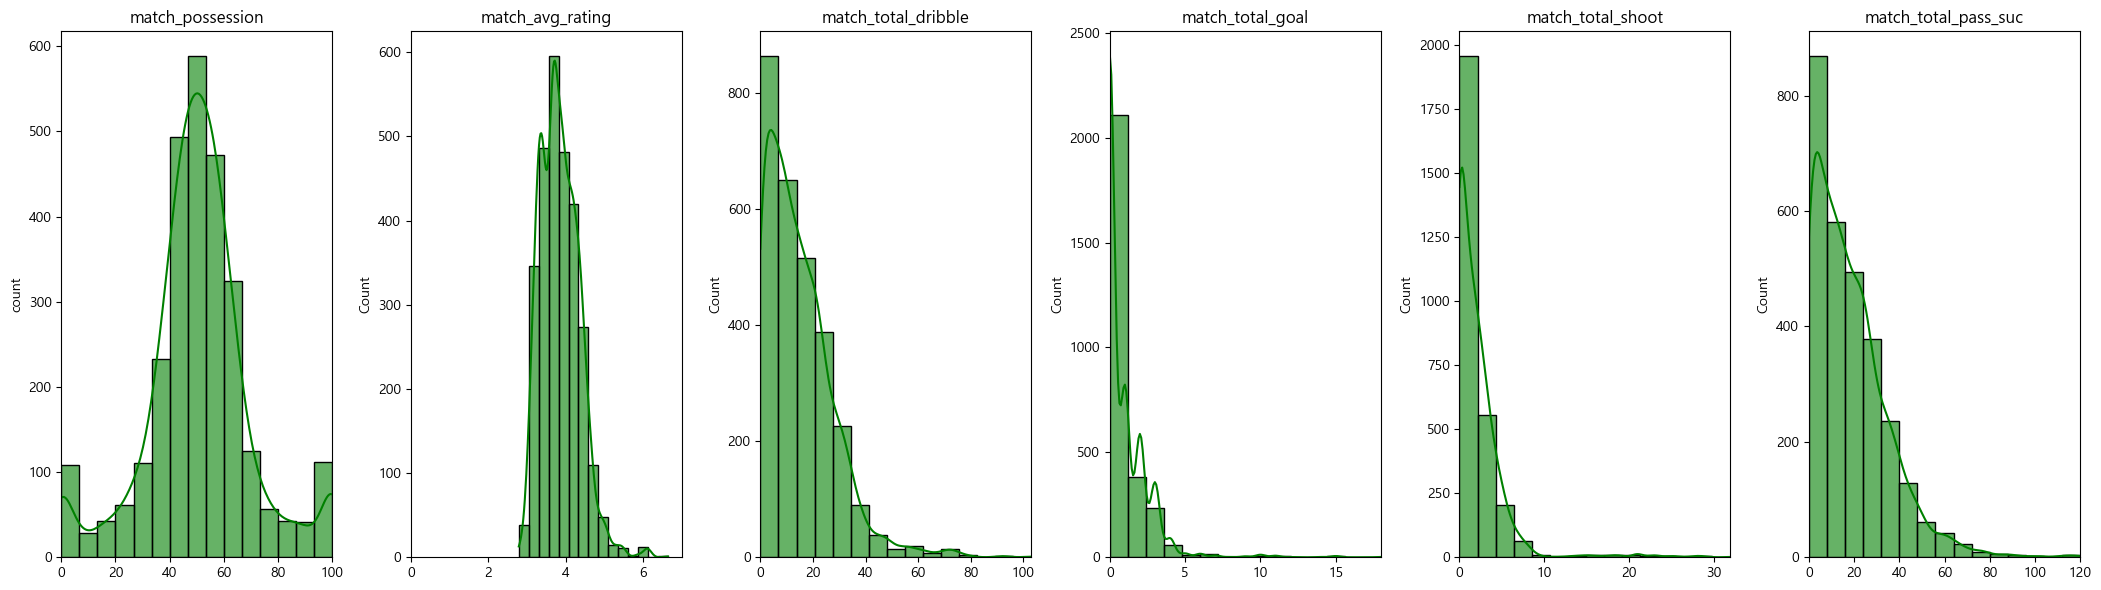

In [21]:
col_hist_all(df3, basic_col)

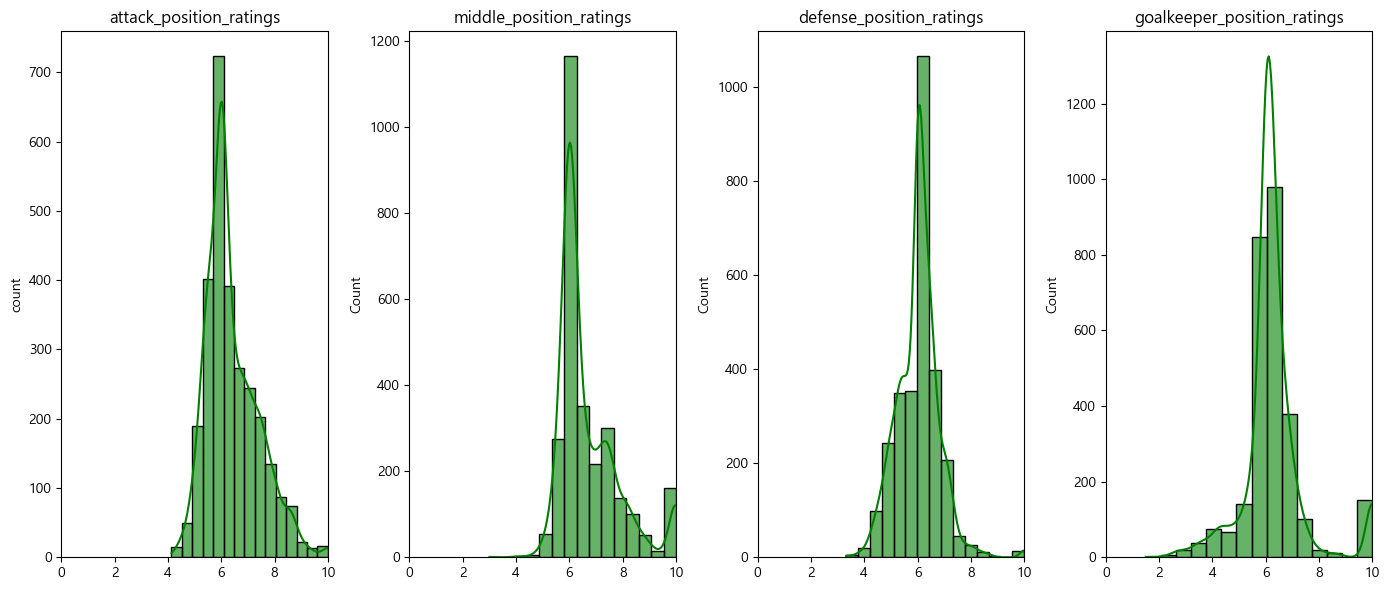

In [22]:
col_hist_all(df3, position_ratings_col)

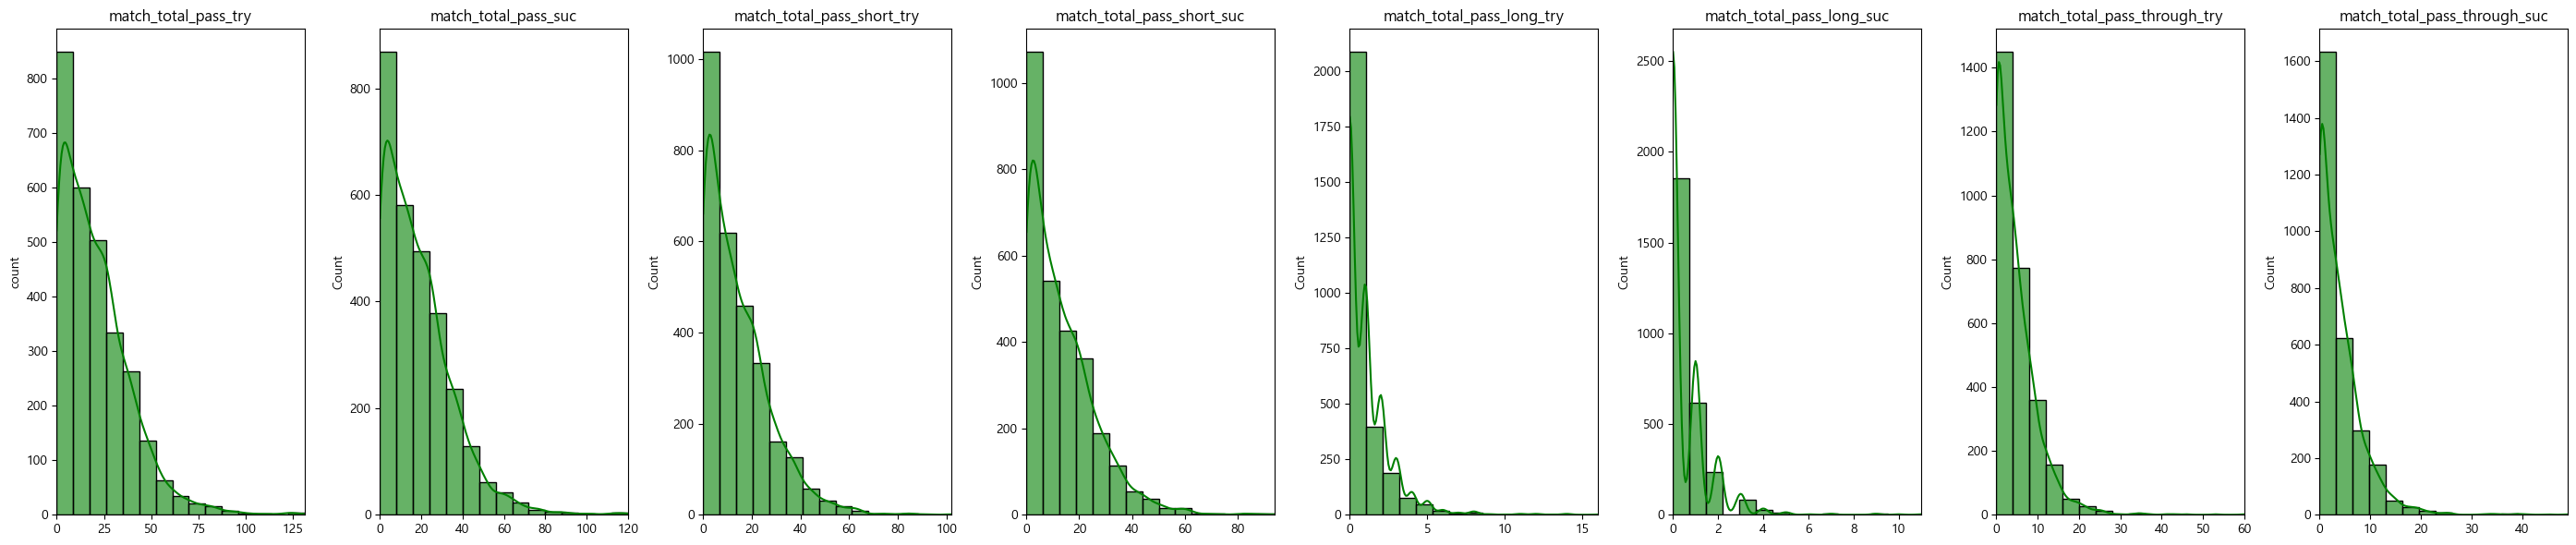

In [23]:
col_hist_all(df3, pass_col)

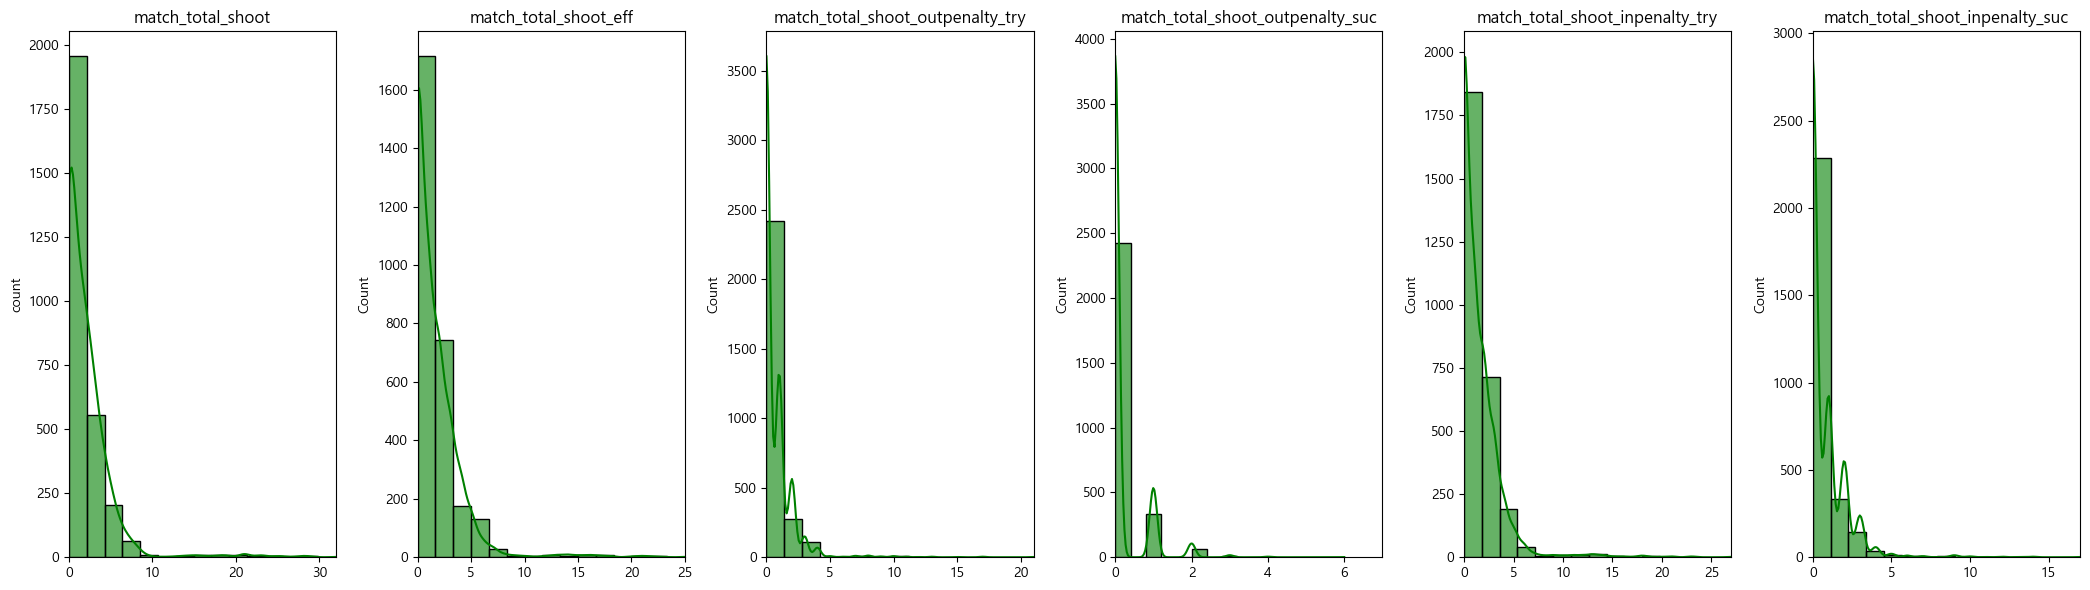

In [24]:
col_hist_all(df3, shoot_col)

---

## 경기 결과에 따른 Stat별 HIST

In [116]:
def col_hist(df_win, df_lose, col_name) : 
    fig, ax = plt.subplots(ncols = len(col_name), 
                           figsize = (3.5 * len(col_name), 6))
                           
    if len(col_name) == 1:
        ax = [ax]
        
    ax[0].set_ylabel('count')

    for idx, col in enumerate(col_name):
        min_val = 0
        max_val = max(df_win[col].max(), df_lose[col].max())
        
        bins = 15
        
        sns.histplot(df_win[col].values, color = 'blue', kde = True, ax = ax[idx], label = '승', 
                     bins = bins, alpha=0.6)
        sns.histplot(df_lose[col].values, color = 'red', kde = True, ax = ax[idx], label = '패', 
                     bins = bins, alpha=0.6)   
        
        ax[idx].set_title(col_name[idx])
        ax[idx].legend()
    
    plt.tight_layout()
    plt.show()

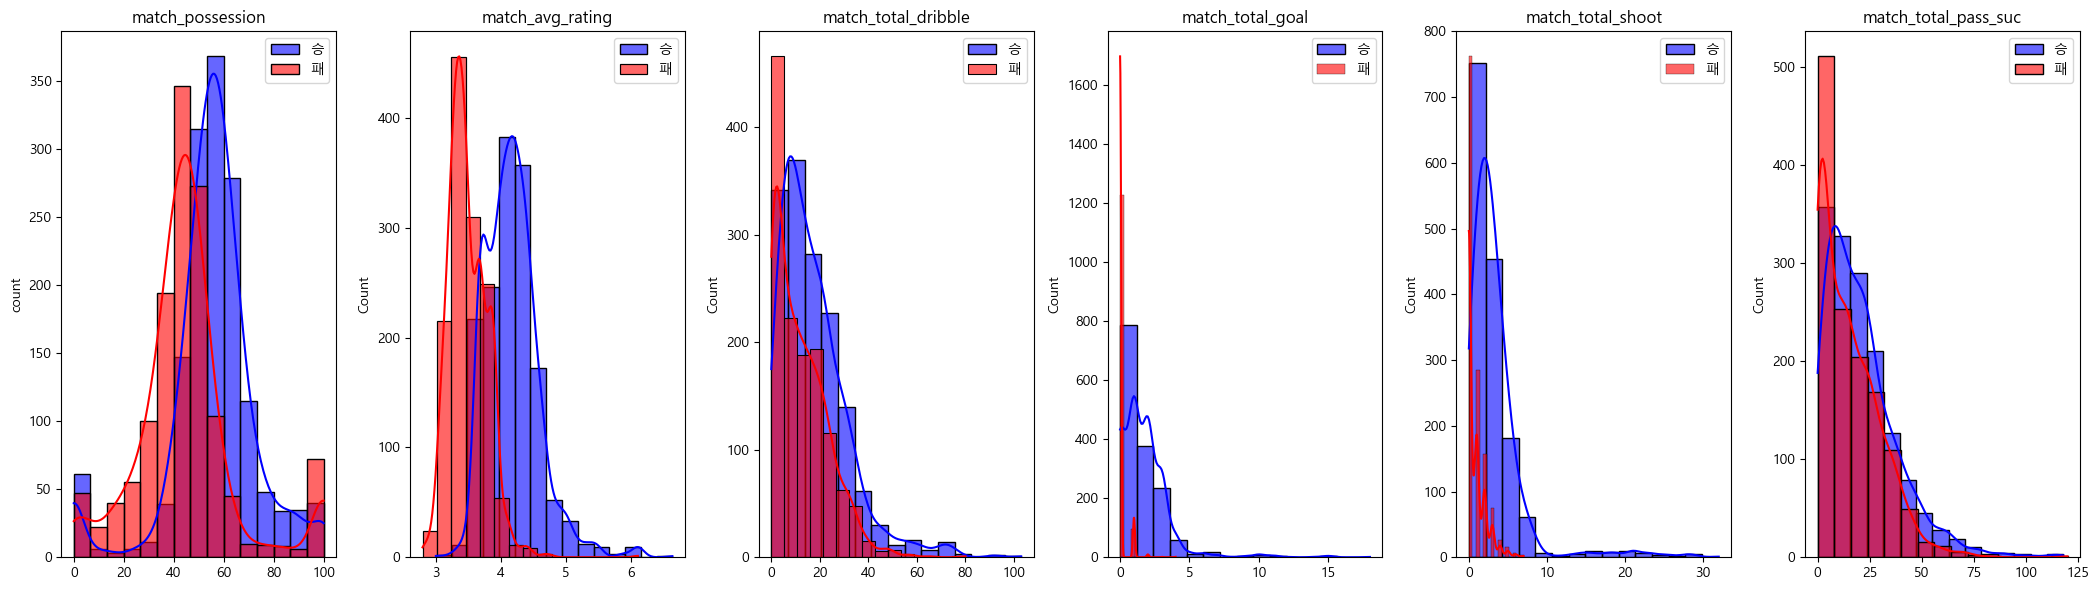

In [117]:
col_hist(df3_win, df3_lose, basic_col)

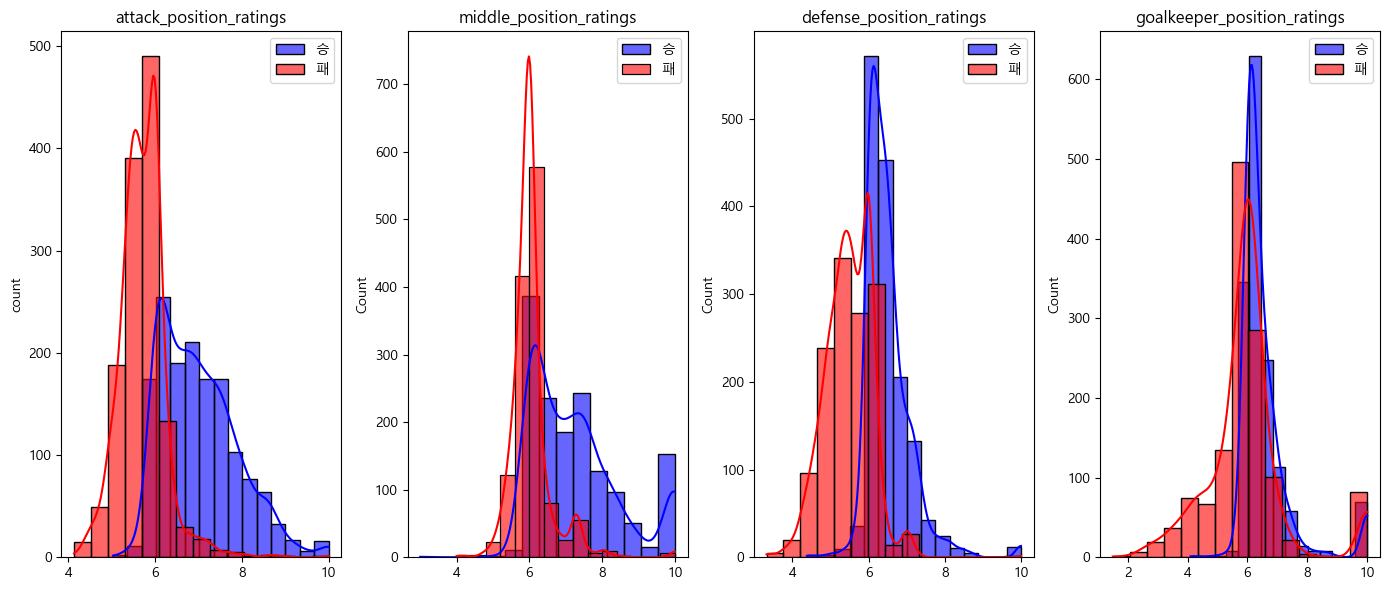

In [118]:
col_hist(df3_win, df3_lose, position_ratings_col)

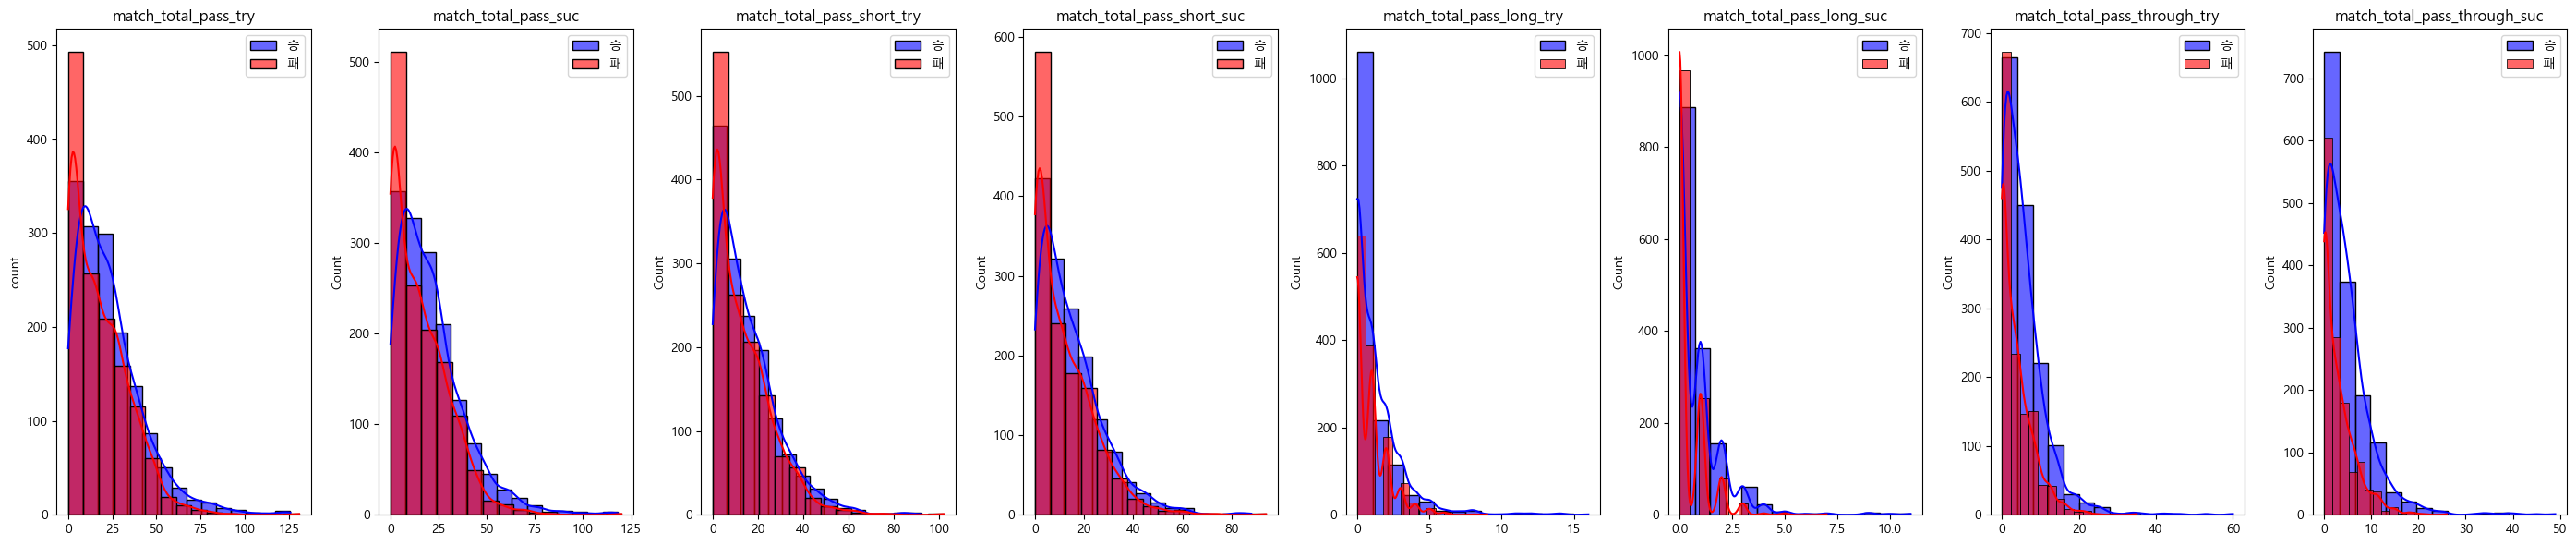

In [119]:
col_hist(df3_win, df3_lose, pass_col)

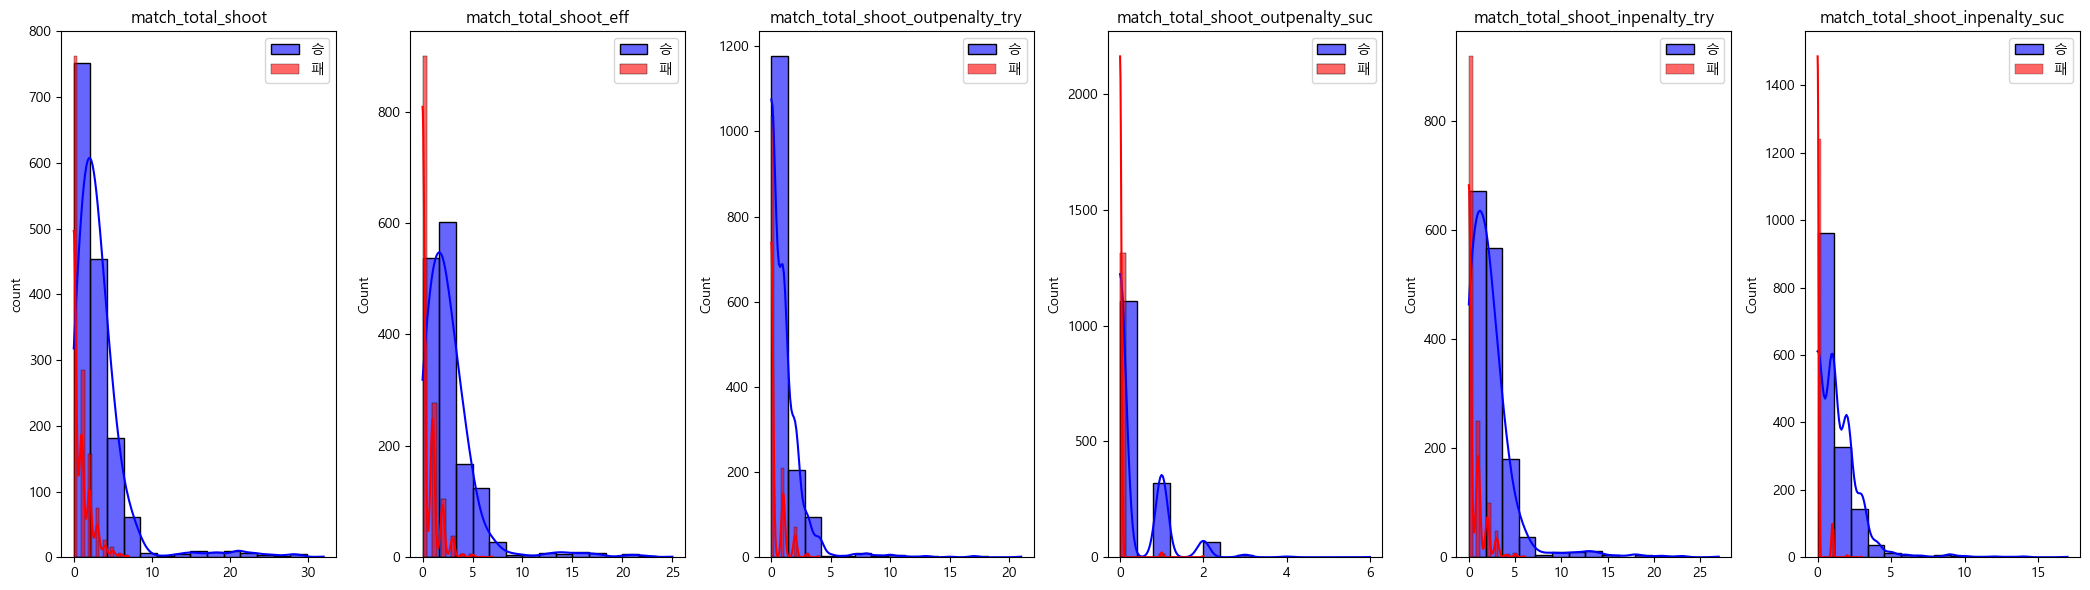

In [120]:
col_hist(df3_win, df3_lose, shoot_col)

## 경기 결과에 따른 Stat별  Box-Plot

In [30]:
def col_boxplot(df_win, df_lose, col_name, sharey_bool) : 

    title_list = ['승', '패']

    fig, ax = plt.subplots(ncols = len(col_name), 
                           figsize = (3.5 * len(col_name), 6), 
                           sharey = sharey_bool)
                           
    if len(col_name) == 1:
        ax = [ax]

    ax[0].set_ylabel('count')

    for idx, col in enumerate(col_name):
        data_to_plot = [df_win[col].values, df_lose[col].values]
        ax[idx].boxplot(data_to_plot, tick_labels = title_list);  

        ax[idx].set_xticks([i for i in range(1, len(title_list) + 1)])
        ax[idx].set_xticklabels(title_list)

        ax[idx].set_title(col_name[idx])

### 결과에 따른 Basic Stats

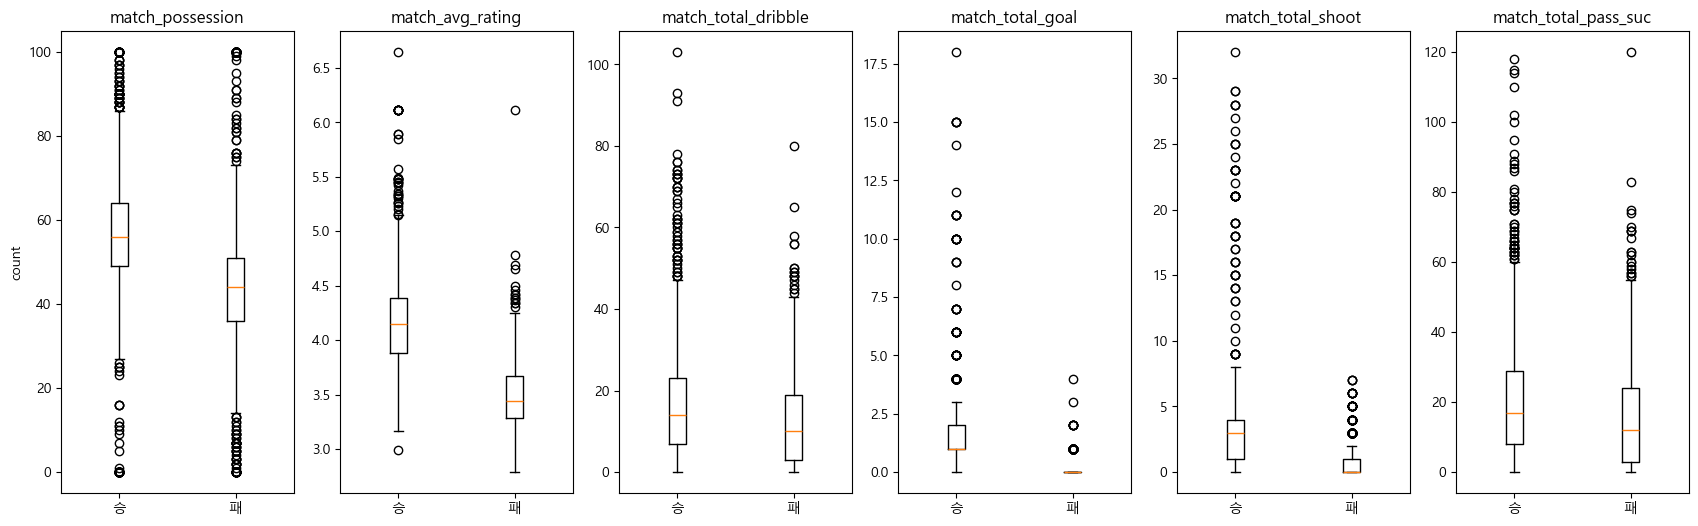

In [31]:
col_boxplot(df3_win, df3_lose, basic_col, False)

### 결과에 따른 Position 별 Ratings

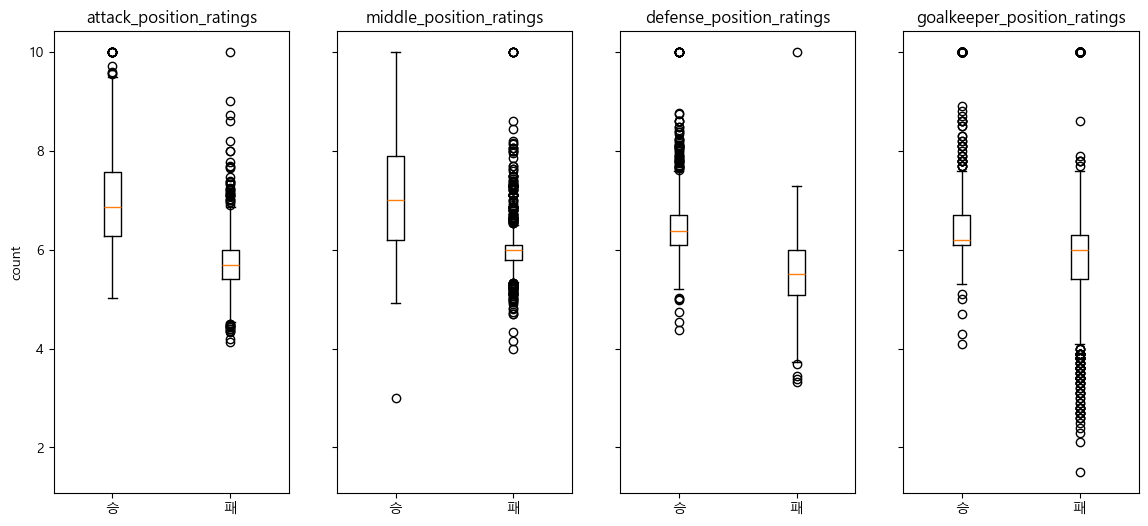

In [32]:
col_boxplot(df3_win, df3_lose, position_ratings_col, True)

### 경기 결과에 따른 Pass stats

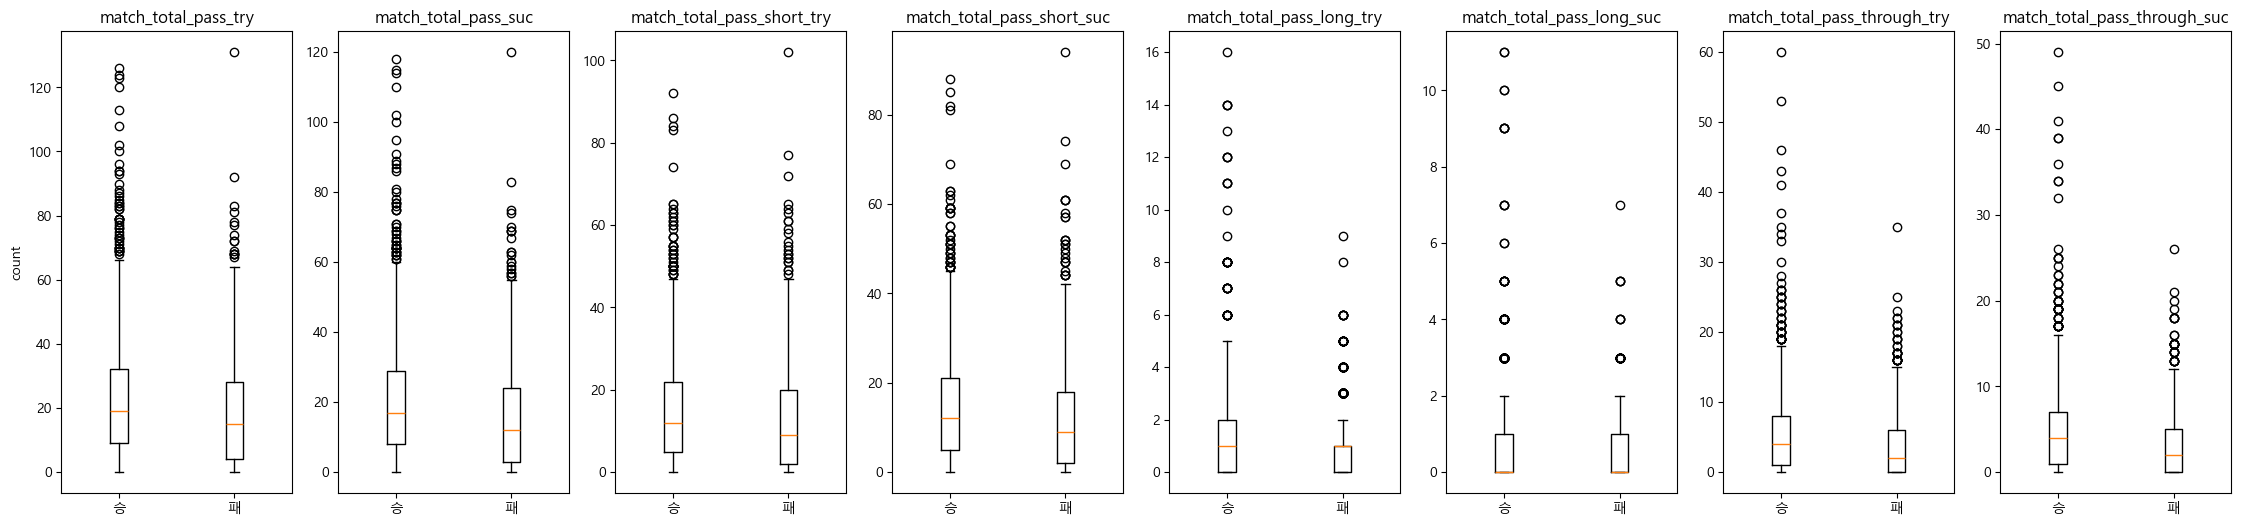

In [33]:
col_boxplot(df3_win, df3_lose, pass_col, False)

### 경기 결과에 따른 Shoot stats

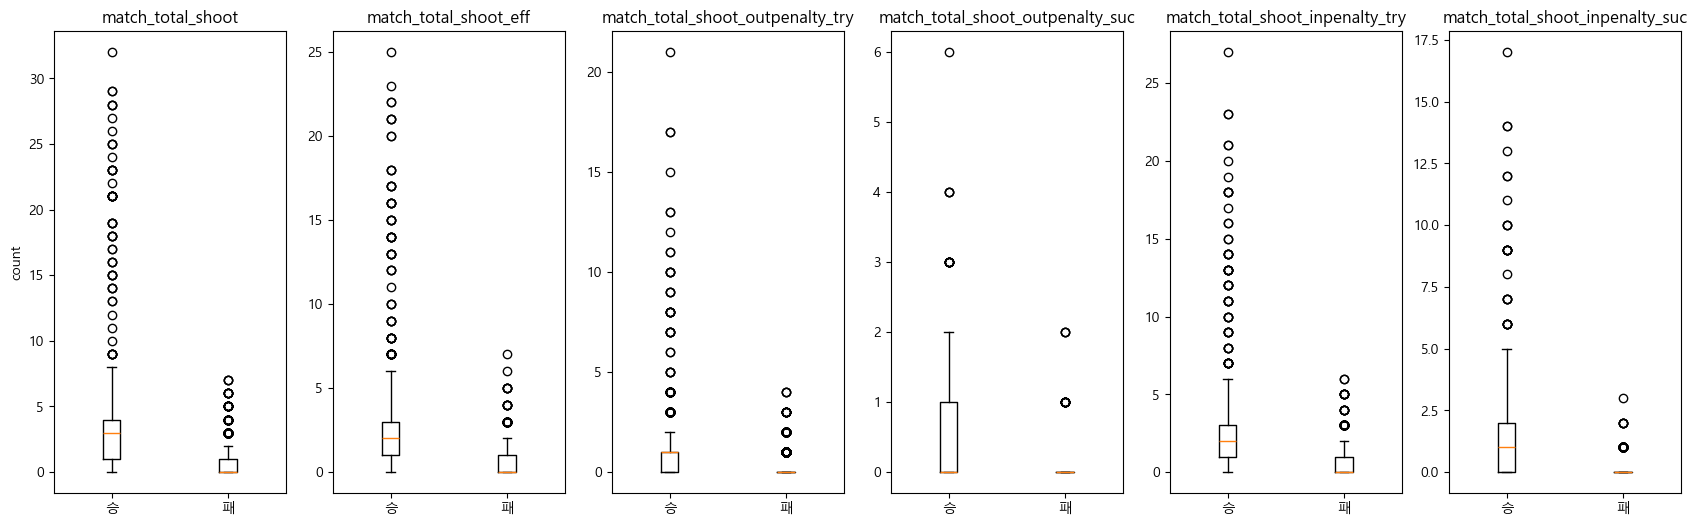

In [34]:
col_boxplot(df3_win, df3_lose, shoot_col, False)

---

In [35]:
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu, kstest, norm, probplot

from sklearn.preprocessing import power_transform

In [36]:
df3_qq = df3.copy()

## Stat별 QQ plot

In [65]:
def col_qqplot_all(df, col_name) : 
    fig, ax = plt.subplots(ncols = len(col_name), 
                           figsize = (3.5 * len(col_name), 6))
                           
    if len(col_name) == 1:
        ax = [ax]

    ax[0].set_ylabel('count')

    for idx, col in enumerate(col_name):
        stats.probplot(df[col], dist = "norm", plot = ax[idx])
        
        ax[idx].set_title(col_name[idx])

    plt.tight_layout()
    plt.show()

In [66]:
def col_qqplot_norm_all(df, col_name) : 
    fig, ax = plt.subplots(ncols = len(col_name), 
                           figsize = (3.5 * len(col_name), 6))
                           
    if len(col_name) == 1:
        ax = [ax]

    ax[0].set_ylabel('count')
    
    for idx, col in enumerate(col_name):
        df[col] = power_transform(df[col].values.reshape(-1, 1), method = 'yeo-johnson')

        stats.probplot(df[col], dist = "norm", plot = ax[idx])
        
        ax[idx].set_title(col_name[idx])

    plt.tight_layout()
    plt.show()

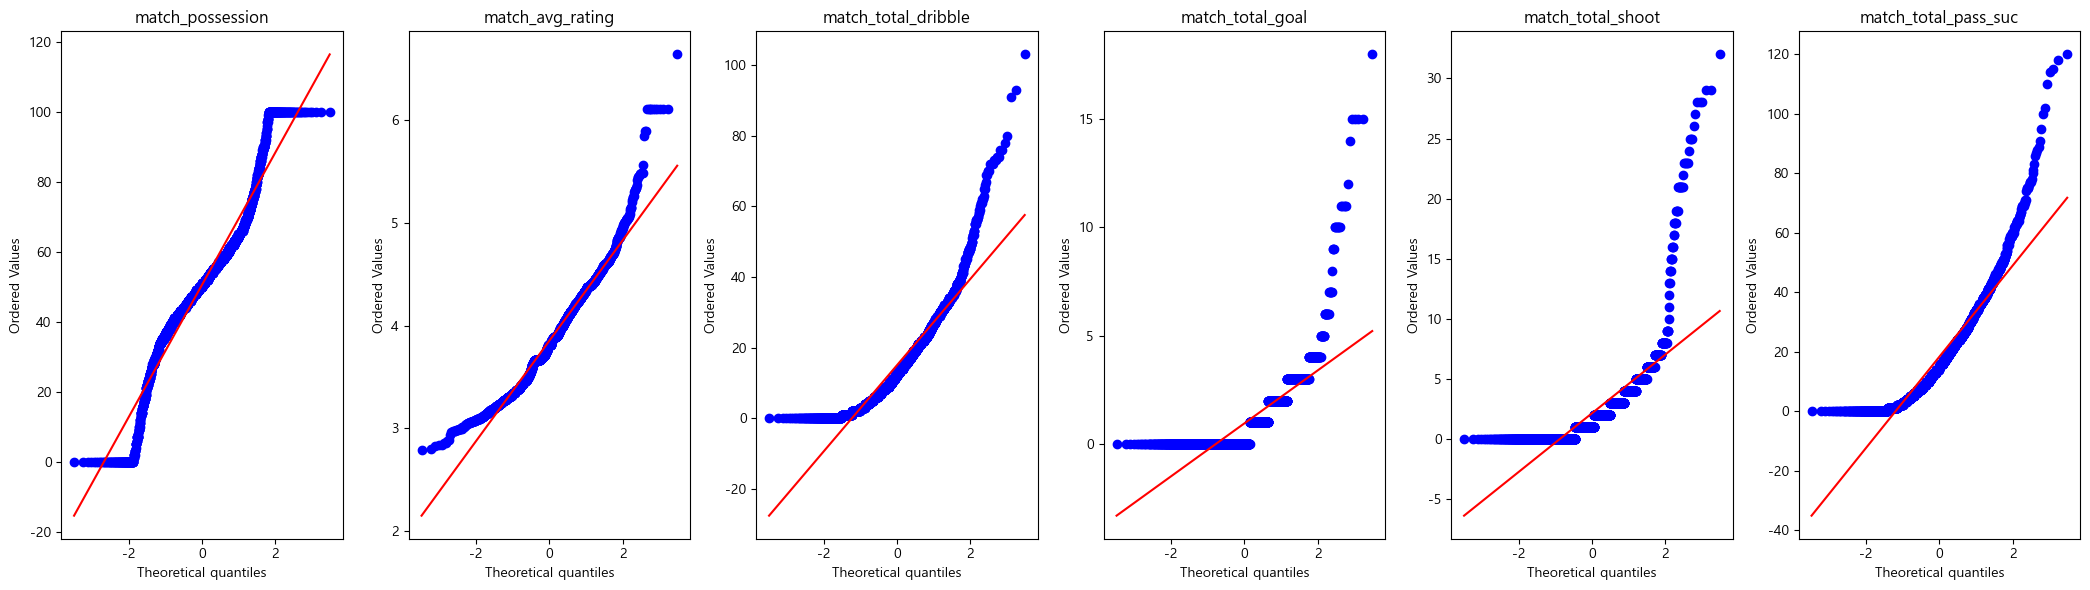

In [76]:
col_qqplot_all(df3, basic_col)

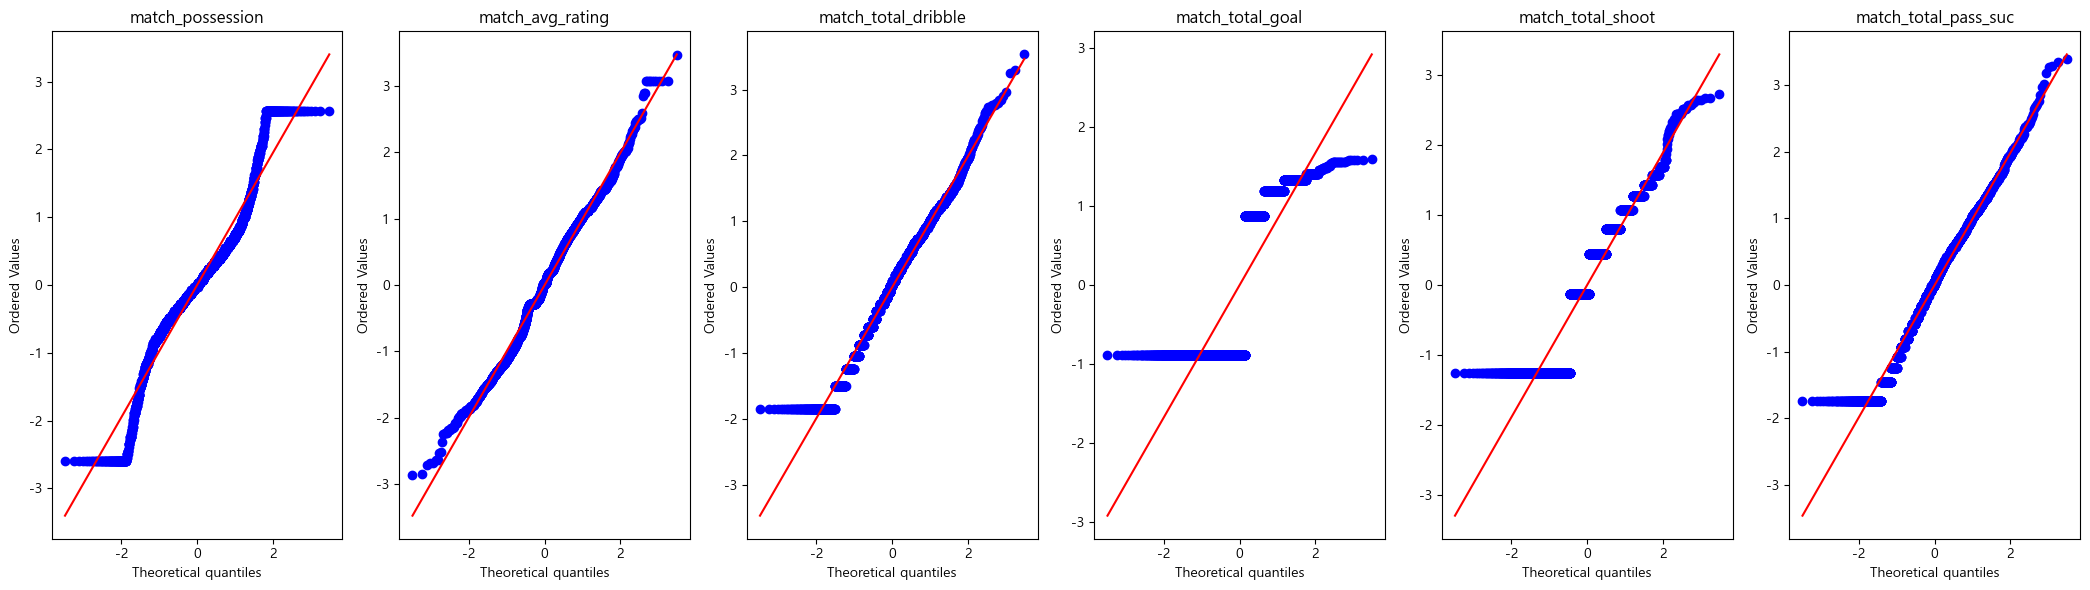

In [68]:
col_qqplot_norm_all(df3_qq, basic_col)

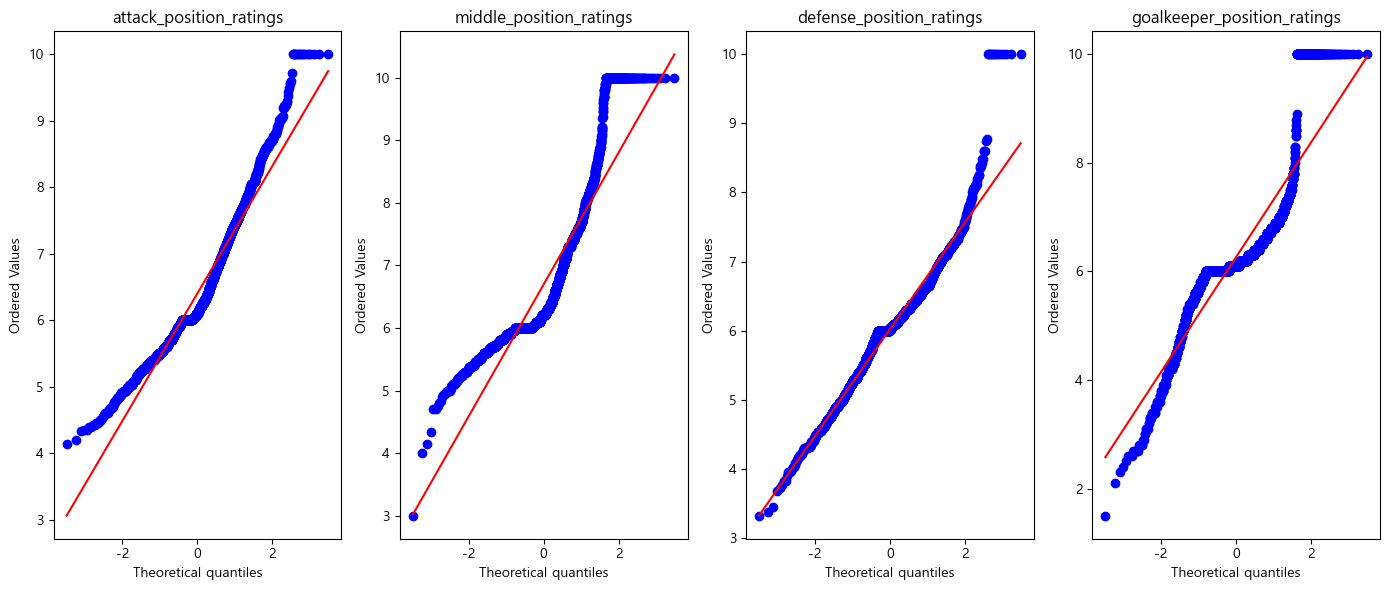

In [77]:
col_qqplot_all(df3, position_ratings_col)

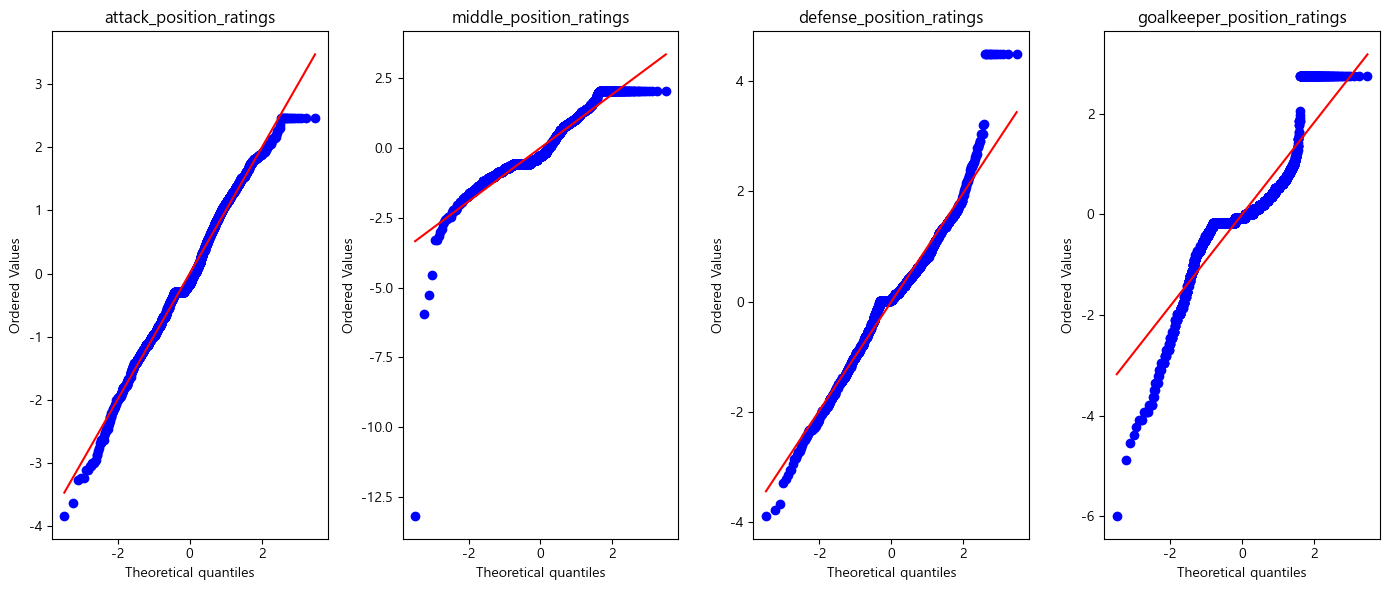

In [70]:
col_qqplot_norm_all(df3_qq, position_ratings_col)

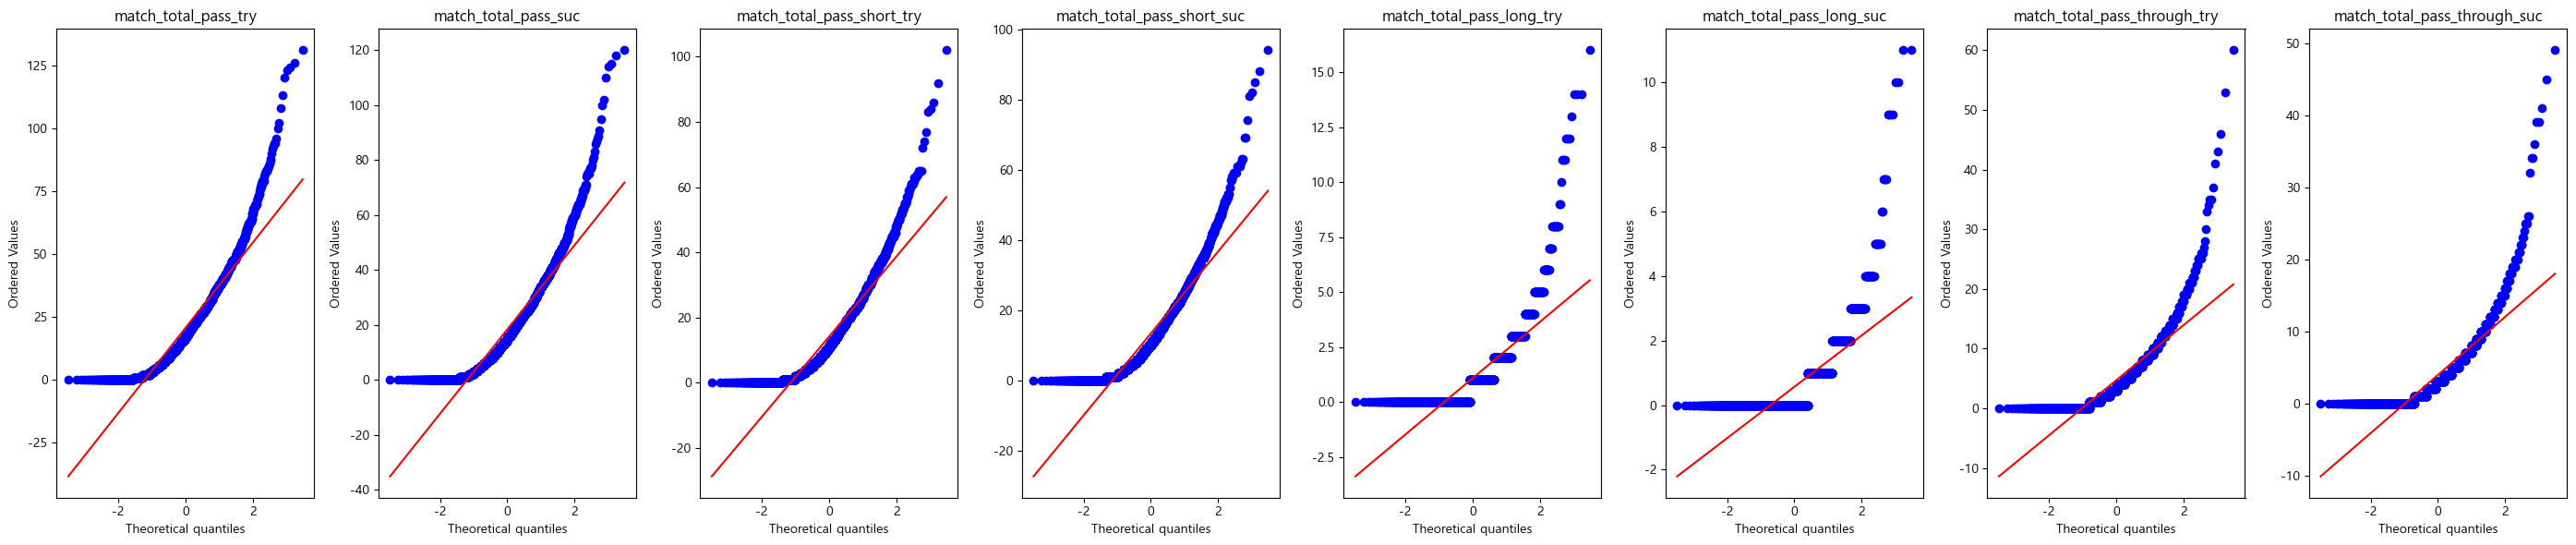

In [71]:
col_qqplot_all(df3, pass_col)

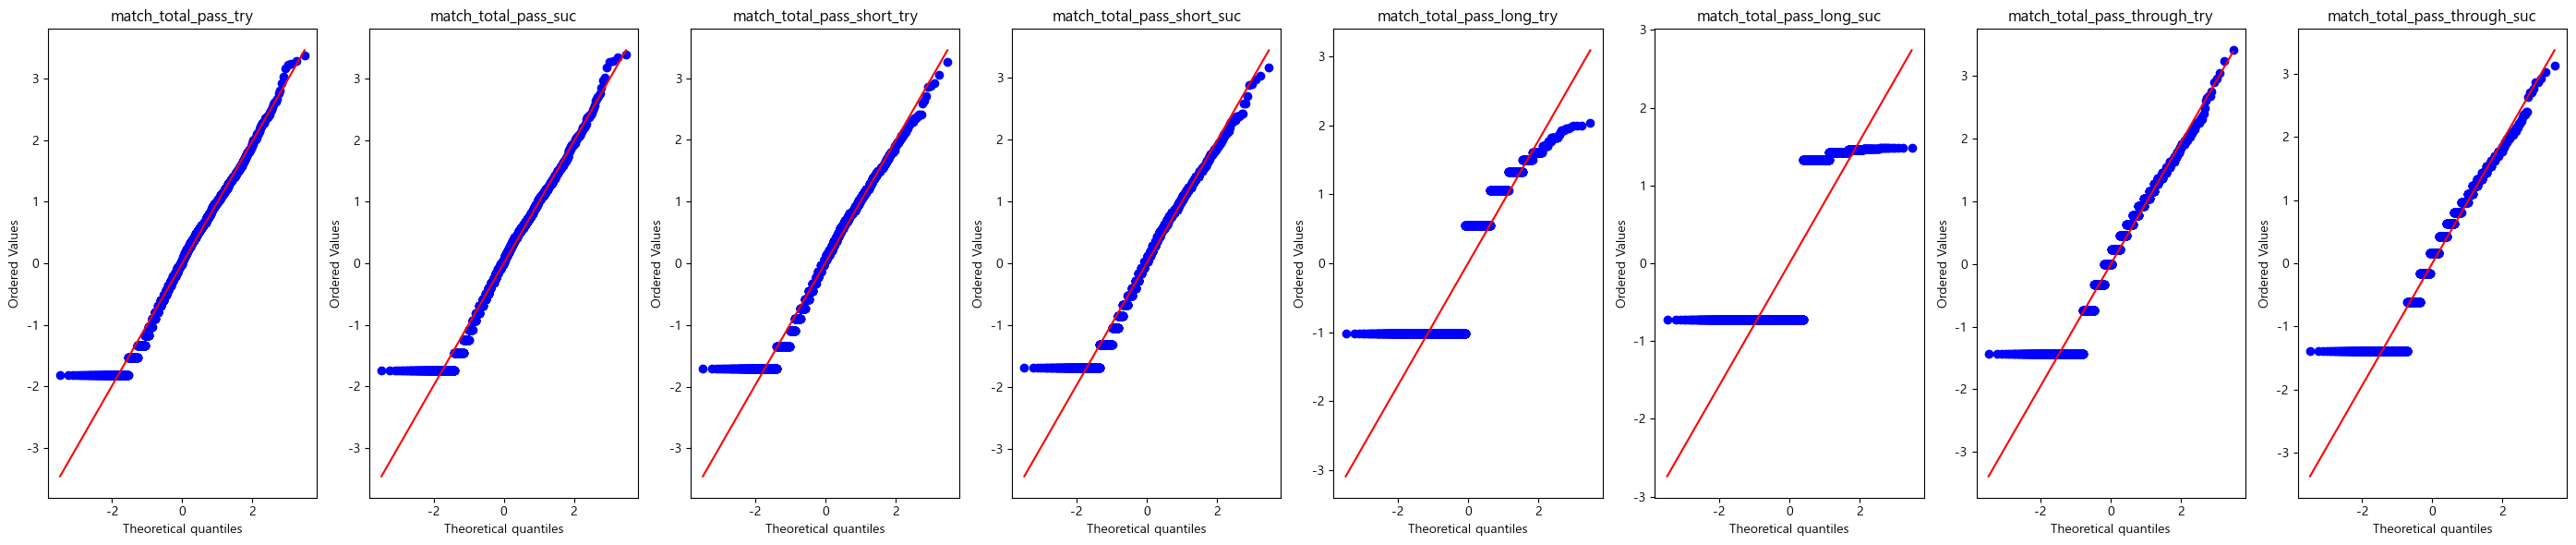

In [72]:
col_qqplot_norm_all(df3_qq, pass_col)

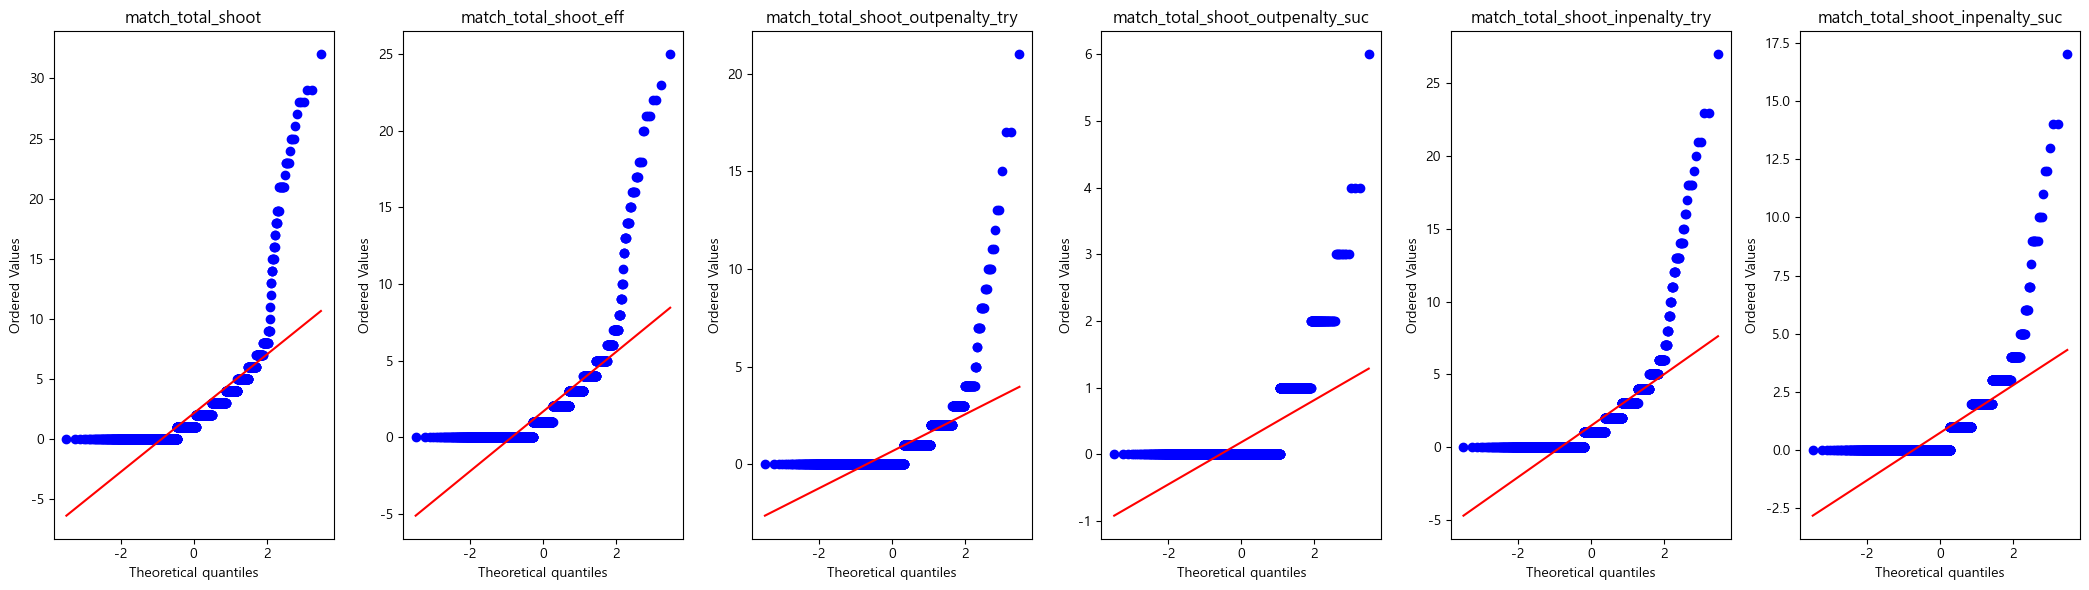

In [73]:
col_qqplot_all(df3, shoot_col)

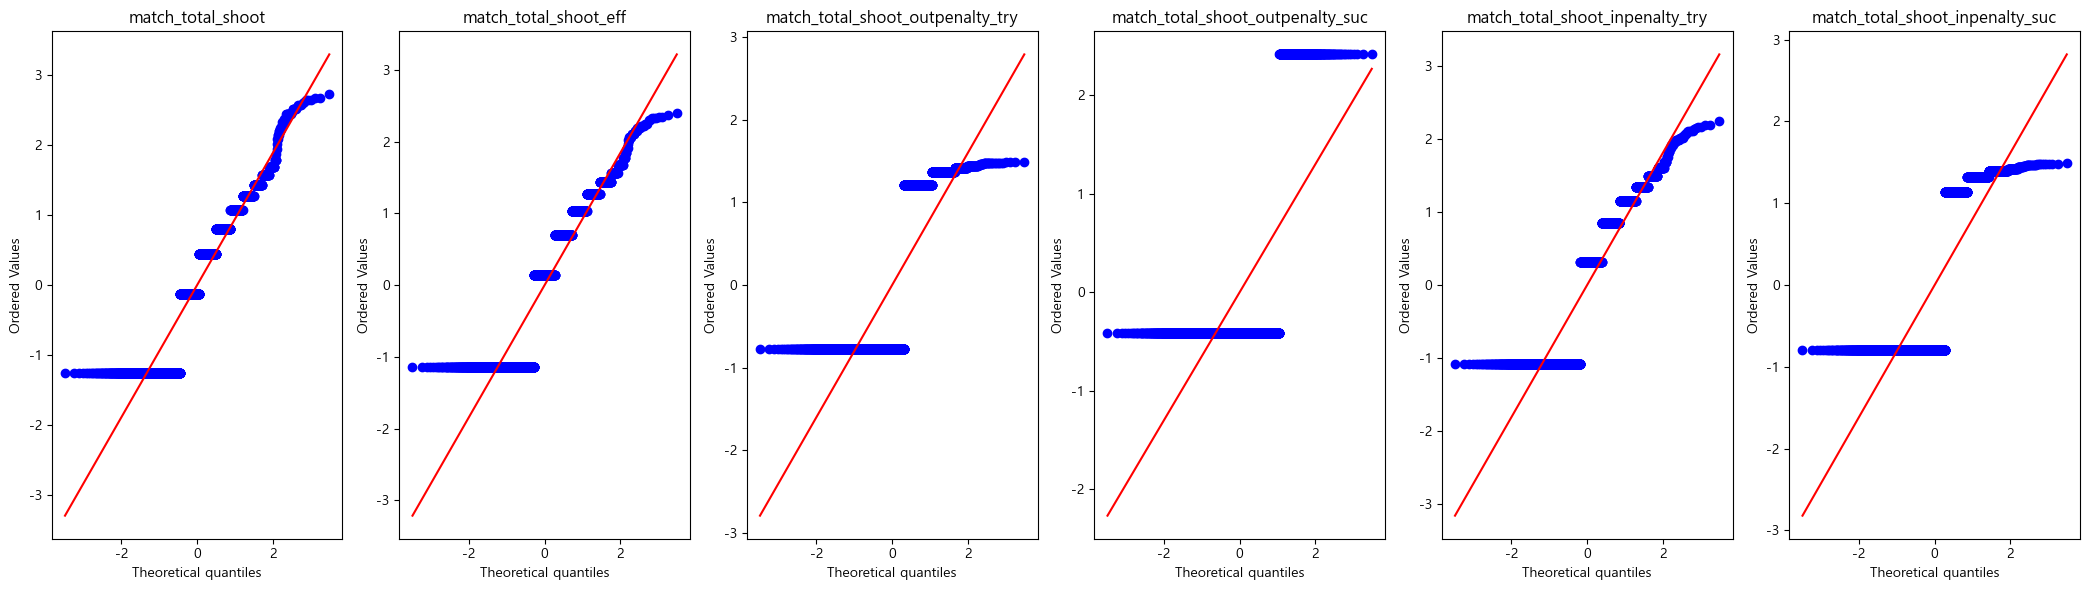

In [74]:
col_qqplot_norm_all(df3_qq, shoot_col)

---

---

In [47]:
# 1. 정규성 검정 (Shapiro-Wilk test)
def normality_test(df_win, df_lose, columns):
    columns_normality_O = []
    columns_normality_X = []
    
    columns_homogeneity_O = []
    columns_homogeneity_X = []

    for col in columns:
        stat_win_shap, p_val_win_shap = shapiro(df_win[col])
        stat_lose_shap, p_val_lose_shap = shapiro(df_lose[col])
        
        stat_win_kosm, p_val_win_kosm = kstest(df_win[col], 'norm', args=(df_win[col].mean(), df_win[col].std()))
        stat_lose_kosm, p_val_lose_kosm = kstest(df_lose[col], 'norm', args=(df_lose[col].mean(), df_lose[col].std()))
        
        stat, p_val = levene(df_win[col], df_lose[col])

        print(f'{col} \n 승: p-value={p_val_win_shap, p_val_win_kosm} \
                      \n 패: p-value={p_val_lose_shap, p_val_lose_kosm} \
                      \n Levene’s test p-value={p_val}')
              
        if p_val_win_shap > 0.05 and p_val_lose_shap > 0.05:
            columns_normality_O.append(col) 

        else:
            if p_val_win_kosm > 0.05 and p_val_lose_kosm > 0.05:
                columns_normality_O.append(col)  

            else:
                columns_normality_X.append(col) 

        # 등분산성 검정 결과
        if p_val > 0.05:
            columns_homogeneity_O.append(col)  
            
        else:
            columns_homogeneity_X.append(col) 

    print('-----------------------------------------------------')
    print(f"정규분포 O: \n {', '.join(columns_normality_O)}")
    print('-----------------------------------------------------')
    print(f"정규분포 X: \n {', '.join(columns_normality_X)}")
    print('-----------------------------------------------------')
    print(f"등분산성 O: \n {', '.join(columns_homogeneity_O)}")
    print('-----------------------------------------------------')
    print(f"등분산성 X: \n {', '.join(columns_homogeneity_X)}")
    print('-----------------------------------------------------')

In [48]:
normality_test(df3_win, df3_lose, basic_col)

match_possession 
 승: p-value=(5.935379116954402e-31, 1.3380833567564825e-21)                       
 패: p-value=(5.886394975938547e-29, 1.1478557473681182e-23)                       
 Levene’s test p-value=0.012549646040513018
match_avg_rating 
 승: p-value=(1.0763036381994577e-26, 4.5377200478118223e-08)                       
 패: p-value=(4.4315391785077026e-21, 1.9875185766544254e-08)                       
 Levene’s test p-value=5.1272281183398695e-18
match_total_dribble 
 승: p-value=(6.549241657039899e-33, 4.181311620407435e-16)                       
 패: p-value=(1.8382034383207595e-28, 2.1035754621395002e-20)                       
 Levene’s test p-value=1.3103672580090575e-06
match_total_goal 
 승: p-value=(8.774614619290709e-45, 3.0237052365560305e-56)                       
 패: p-value=(1.680535454207698e-57, 0.0)                       
 Levene’s test p-value=2.0523338798328432e-125
match_total_shoot 
 승: p-value=(3.0616204383197552e-49, 7.024313787445983e-69)                 

In [49]:
normality_test(df3_win, df3_lose, position_ratings_col)

attack_position_ratings 
 승: p-value=(9.31242048235124e-24, 1.167155455723347e-10)                       
 패: p-value=(2.5796906008506833e-25, 1.0638470360683403e-12)                       
 Levene’s test p-value=1.0942248374917654e-70
middle_position_ratings 
 승: p-value=(1.299561515316271e-31, 1.91511453300061e-18)                       
 패: p-value=(7.50929478123333e-39, 2.959182460582386e-54)                       
 Levene’s test p-value=4.670362614388794e-129
defense_position_ratings 
 승: p-value=(2.85010740508106e-37, 1.8896573330509482e-28)                       
 패: p-value=(5.8138132878533035e-15, 6.152807420751613e-06)                       
 Levene’s test p-value=2.752225445967105e-06
goalkeeper_position_ratings 
 승: p-value=(1.5650874898757576e-48, 1.6688729092627415e-80)                       
 패: p-value=(4.1526424346161524e-34, 1.2567321770874771e-42)                       
 Levene’s test p-value=6.808029082920177e-21
-----------------------------------------------------

In [50]:
normality_test(df3_win, df3_lose, pass_col)

match_total_pass_try 
 승: p-value=(1.1052601992646779e-31, 9.027938549438186e-17)                       
 패: p-value=(7.425342784937636e-29, 2.5907261639718376e-21)                       
 Levene’s test p-value=0.008527096481622991
match_total_pass_suc 
 승: p-value=(8.883031219512443e-32, 2.5768710209528287e-17)                       
 패: p-value=(5.6911312898653954e-30, 3.301532579823402e-24)                       
 Levene’s test p-value=0.0006601240574348132
match_total_pass_short_try 
 승: p-value=(7.229373126409047e-32, 9.69958453724729e-21)                       
 패: p-value=(1.7323760185519656e-32, 1.3693101177545754e-29)                       
 Levene’s test p-value=0.30390319444146324
match_total_pass_short_suc 
 승: p-value=(5.020918757136039e-32, 3.0337103923210168e-21)                       
 패: p-value=(7.14861225578693e-33, 9.085979883396704e-31)                       
 Levene’s test p-value=0.08365975290677732
match_total_pass_long_try 
 승: p-value=(4.513939010550249e-47, 2

In [51]:
normality_test(df3_win, df3_lose, shoot_col)

match_total_shoot 
 승: p-value=(3.0616204383197552e-49, 7.024313787445983e-69)                       
 패: p-value=(2.36858109170826e-43, 9.487712292481794e-122)                       
 Levene’s test p-value=3.1757499611929044e-42
match_total_shoot_eff 
 승: p-value=(1.201192576299291e-46, 4.129273275216606e-60)                       
 패: p-value=(4.092092626298465e-47, 1.309720967214775e-183)                       
 Levene’s test p-value=9.392397229016706e-59
match_total_shoot_outpenalty_try 
 승: p-value=(3.6652057676516276e-52, 7.69329340490785e-106)                       
 패: p-value=(1.9457344844530144e-50, 2.865684703316727e-259)                       
 Levene’s test p-value=9.400243475321564e-54
match_total_shoot_outpenalty_suc 
 승: p-value=(2.0941524520920926e-51, 2.354346272448411e-261)                       
 패: p-value=(3.860997500435917e-62, 0.0)                       
 Levene’s test p-value=2.4991195165461805e-69
match_total_shoot_inpenalty_try 
 승: p-value=(1.186503309073045

In [52]:
def group_difference_test(df_win, df_lose, columns):
    for col in columns:
        # 정규성 여부에 따라 검정 방법 선택
        stat_win_shap, p_val_win_shap = shapiro(df_win[col])
        stat_lose_shap, p_val_lose_shap = shapiro(df_lose[col])
        
        stat_win_kosm, p_val_win_kosm = kstest(df_win[col], 'norm', args=(df_win[col].mean(), df_win[col].std()))
        stat_lose_kosm, p_val_lose_kosm = kstest(df_lose[col], 'norm', args=(df_lose[col].mean(), df_lose[col].std()))
        
        if (p_val_win_shap > 0.05 and p_val_lose_shap > 0.05) or (p_val_win_kosm > 0.05 and p_val_lose_kosm > 0.05):  # 정규분포를 따를 경우
            stat, p_val = ttest_ind(df_win[col], df_lose[col], equal_var=True)  
            test_type = "t-test"
            
        else:  # 정규분포를 따르지 않을 경우
            stat, p_val = mannwhitneyu(df_win[col], df_lose[col])
            test_type = "Mann-Whitney U test"
        
        print('-----------------------------------------------------')

        if p_val < 0.05:
            print(f'{col}은(는) 승패에 따라 유의미한 차이가 있음')
        else:
            print(f'{col}은(는) 승패에 따른 차이가 없음, XXXXXXXXXXXXXXXX')

In [53]:
group_difference_test(df3_win, df3_lose, basic_col)

-----------------------------------------------------
match_possession은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_avg_rating은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_dribble은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_goal은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_suc은(는) 승패에 따라 유의미한 차이가 있음


In [54]:
group_difference_test(df3_win, df3_lose, position_ratings_col)

-----------------------------------------------------
attack_position_ratings은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
middle_position_ratings은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
defense_position_ratings은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
goalkeeper_position_ratings은(는) 승패에 따라 유의미한 차이가 있음


In [55]:
group_difference_test(df3_win, df3_lose, shoot_col)

-----------------------------------------------------
match_total_shoot은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_eff은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_outpenalty_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_outpenalty_suc은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_inpenalty_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_inpenalty_suc은(는) 승패에 따라 유의미한 차이가 있음


In [56]:
group_difference_test(df3_win, df3_lose, pass_col)

-----------------------------------------------------
match_total_pass_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_suc은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_short_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_short_suc은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_long_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_long_suc은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_through_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_through_suc은(는) 승패에 따라 유의미한 차이가 있음


---

In [57]:
list(df2_temp.columns)

['match_possession',
 'goalkeeper_position_ratings',
 'match_total_pass_short_suc',
 'match_total_pass_long_try',
 'match_total_pass_long_suc',
 'match_total_pass_through_suc',
 'match_total_shoot_outpenalty_try',
 'match_total_shoot_outpenalty_suc',
 'match_total_shoot_inpenalty_try',
 'match_total_shoot_inpenalty_suc']

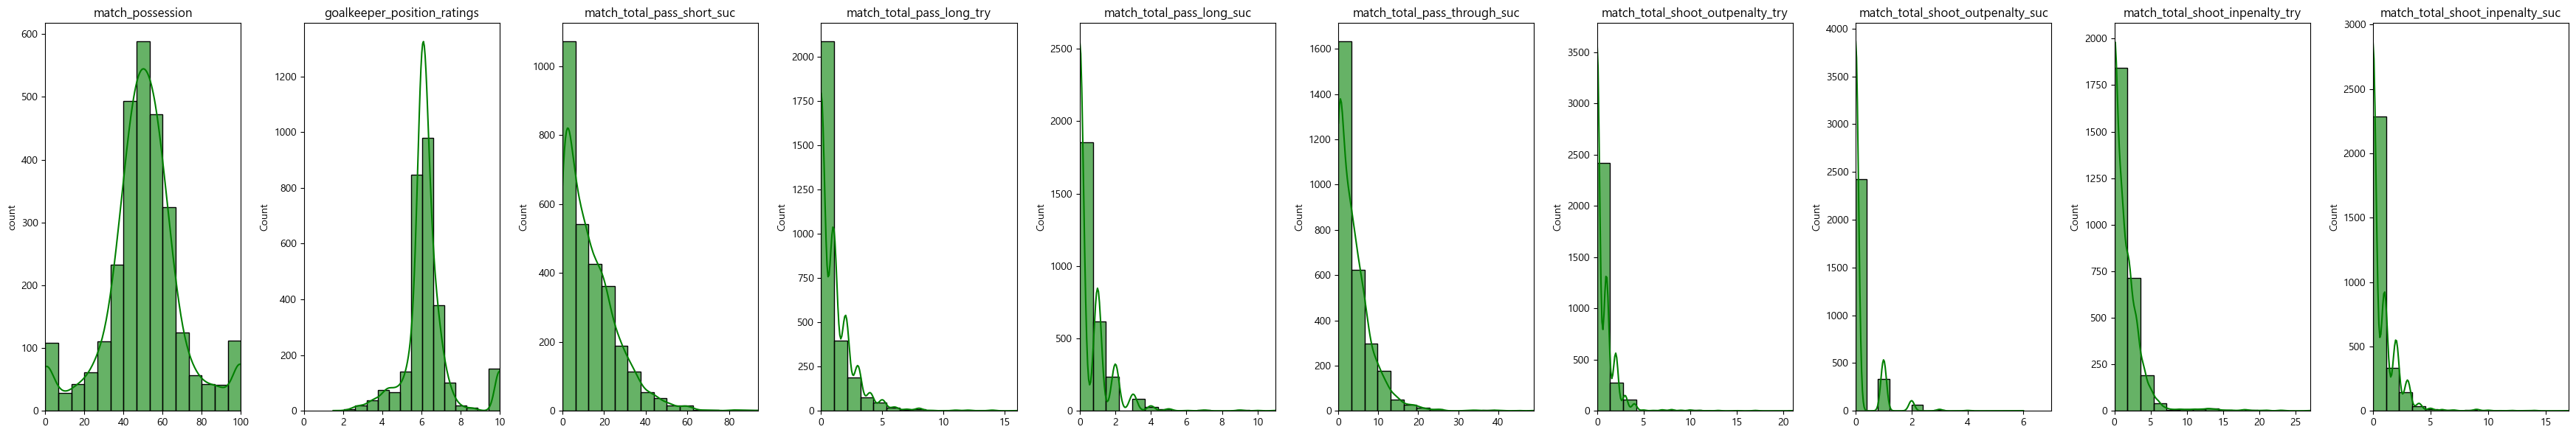

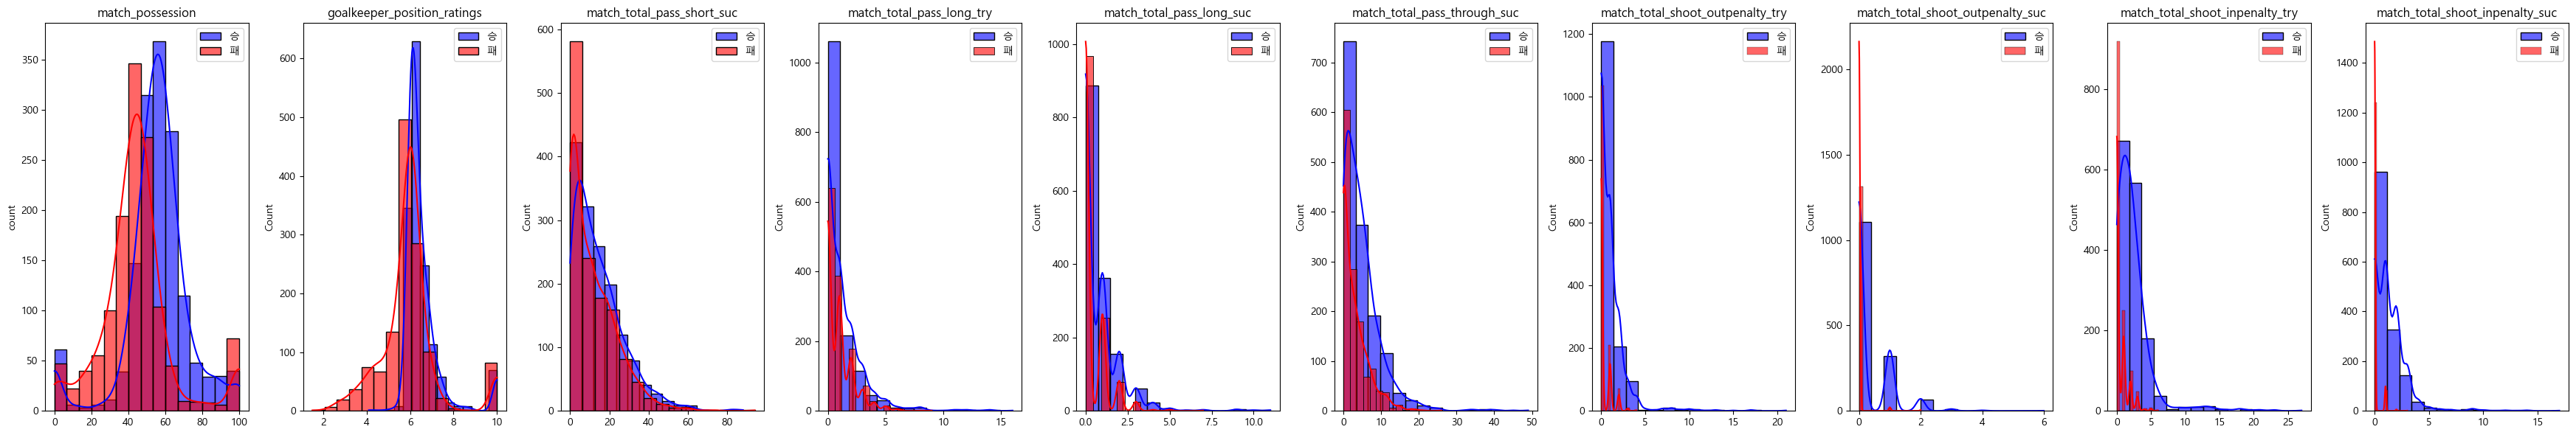

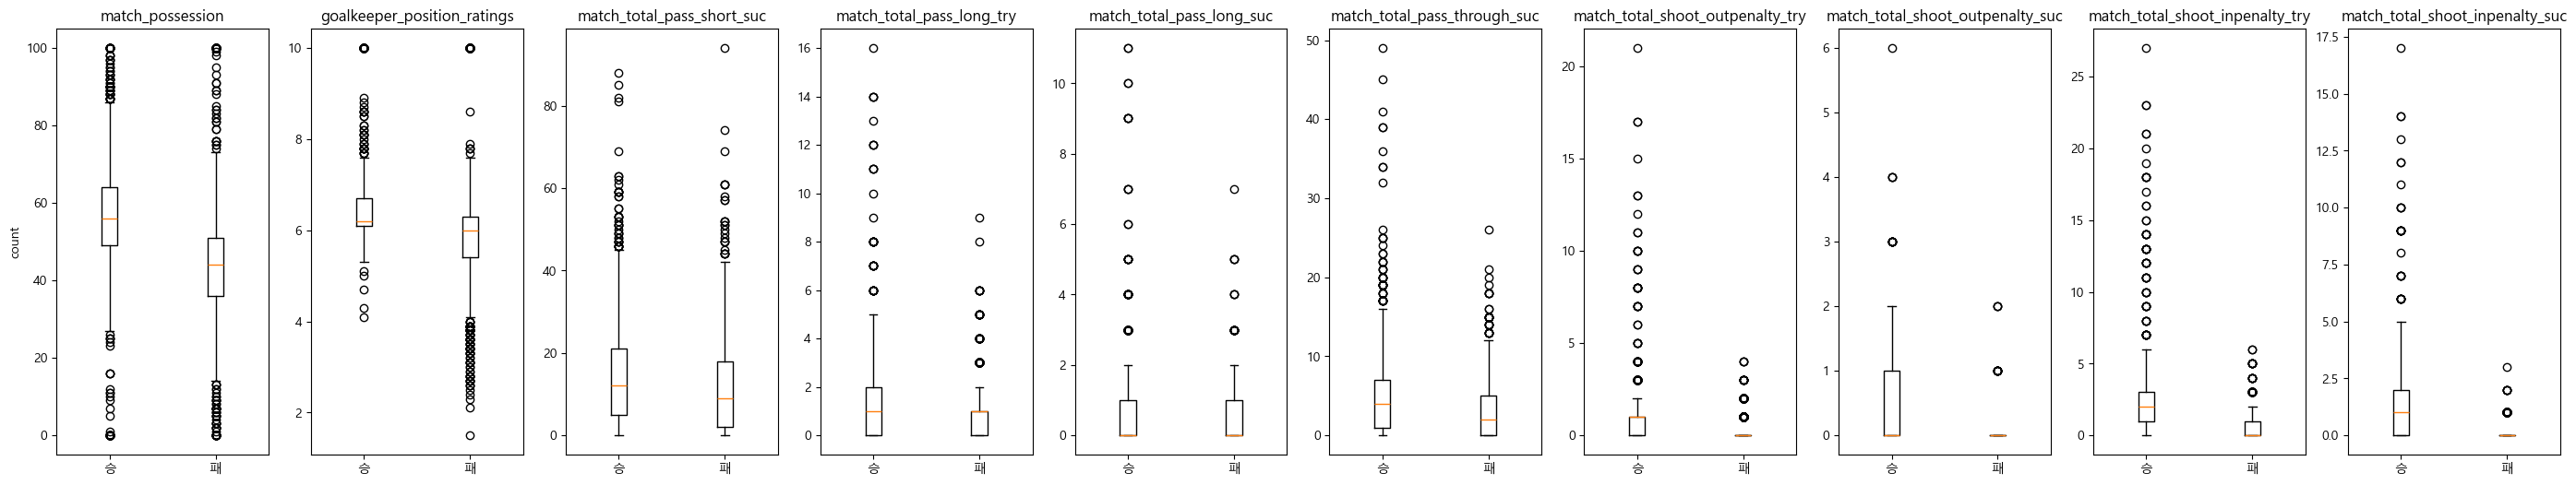

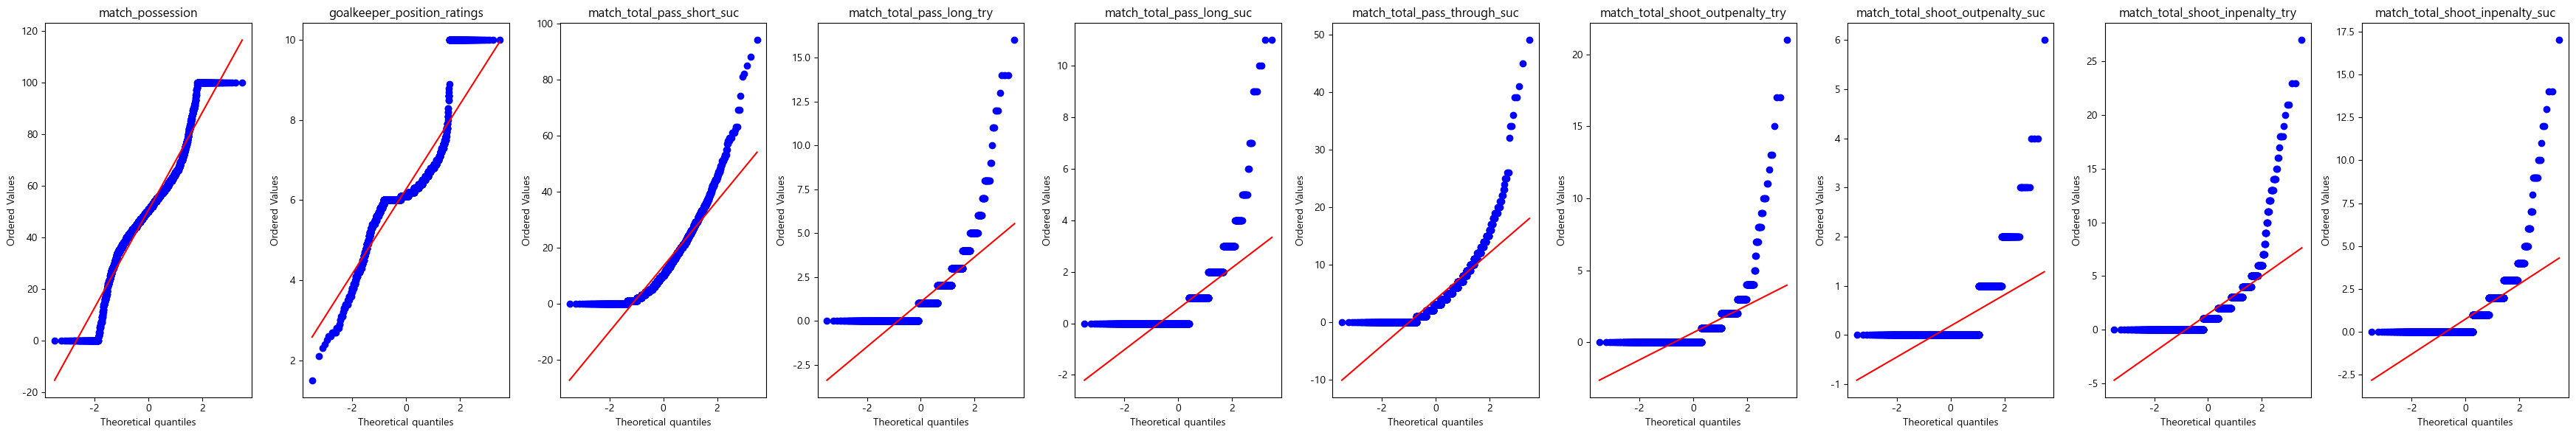

In [75]:
df4 = df1[['match_result'] + list(df2_temp.columns)]

df4_win = df4[df4['match_result'] == '승']
df4_lose = df4[df4['match_result'] == '패']

df4_temp = df4.drop(columns = ['match_result'])

col_hist_all(df4_temp, df4_temp.columns);
col_hist(df4_win, df4_lose, df4_temp.columns, False);
col_boxplot(df4_win, df4_lose, df4_temp.columns, False);
col_qqplot_all(df4_temp, df4_temp.columns);

In [59]:
normality_test(df4_win, df4_lose, df4_temp.columns)

match_possession 
 승: p-value=(5.935379116954402e-31, 1.3380833567564825e-21)                       
 패: p-value=(5.886394975938547e-29, 1.1478557473681182e-23)                       
 Levene’s test p-value=0.012549646040513018
goalkeeper_position_ratings 
 승: p-value=(1.5650874898757576e-48, 1.6688729092627415e-80)                       
 패: p-value=(4.1526424346161524e-34, 1.2567321770874771e-42)                       
 Levene’s test p-value=6.808029082920177e-21
match_total_pass_short_suc 
 승: p-value=(5.020918757136039e-32, 3.0337103923210168e-21)                       
 패: p-value=(7.14861225578693e-33, 9.085979883396704e-31)                       
 Levene’s test p-value=0.08365975290677732
match_total_pass_long_try 
 승: p-value=(4.513939010550249e-47, 2.366313807262465e-84)                       
 패: p-value=(8.091776968401912e-41, 3.852489778265176e-79)                       
 Levene’s test p-value=7.130538687454603e-09
match_total_pass_long_suc 
 승: p-value=(1.2772841405669707e

In [60]:
group_difference_test(df4_win, df4_lose, df4_temp.columns)

-----------------------------------------------------
match_possession은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
goalkeeper_position_ratings은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_short_suc은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_long_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_long_suc은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_pass_through_suc은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_outpenalty_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_outpenalty_suc은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
match_total_shoot_inpenalty_try은(는) 승패에 따라 유의미한 차이가 있음
-----------------------------------------------------
ma

In [61]:
df4

match_result  match_possession  goalkeeper_position_ratings  \
0               승                70                         10.0   
1               승                59                          6.7   
2               패                47                          7.3   
3               승                53                          6.1   
4               승                48                          6.3   
...           ...               ...                          ...   
2833            승                 7                          6.0   
2834            패                10                          5.5   
2835            승                90                          6.1   
2836            승                 0                          6.0   
2837            패               100                          6.0   

      match_total_pass_short_suc  match_total_pass_long_try  \
0                             12                          1   
1                             23                          0   
2                             12                          0   
3                             23                          2   
4                             40                          1   
...                          ...                        ...   
2833                           0                          0   
2834                           1                          0   
2835                          14                          0   
2836                           0                          0   
2837                           1                          1   

      match_total_pass_long_suc  match_total_pass_through_suc  \
0                             0                             5   
1                             0                             5   
2                             0                            11   
3                             0                             6   
4                             1                             2   
...                         ...                           ...   
2833                          0                             0   
2834                          0                             0   
2835                          0                             0   
2836                          0                             0   
2837                          1                             0   

      match_total_shoot_outpenalty_try  match_total_shoot_outpenalty_suc  \
0                                    2                                 1   
1                                    2                                 1   
2                                    0                                 0   
3                                    0                                 0   
4                                    3                                 1   
...                                ...                               ...   
2833                                 0                                 0   
2834                                 0                                 0   
2835                                 0                                 0   
2836                                 0                                 0   
2837                                 0                                 0   

      match_total_shoot_inpenalty_try  match_total_shoot_inpenalty_suc  
0                                   2                                0  
1                                   1                                1  
2                                   0                                0  
3                                   1                                1  
4                                   4                                2  
...                               ...                              ...  
2833                                0                                0  
2834                                0                                0  
2835                                1                                1  
2836   

---

# PRACTICE

In [62]:
# match_total_goal, match_possession, match_total_shoot_inpenalty_try, 
# match_total_pass_short_try, match_total_pass_long_try, match_total_pass_through_try
# match_total_shoot_outpenalty_try, match_total_shoot_inpenalty_try

column_name = 'match_total_shoot_inpenalty_try'

temp_query = f"SELECT match_result, {column_name} FROM match_user;"
df_temp = pd.read_sql(temp_query, con = engine);

df_temp[column_name] += 0.1
df_temp[f'{column_name}_boxcox'] = stats.boxcox(df_temp[column_name])[0] 

x = df_temp[column_name]
x_win = df_temp[df_temp['match_result'] == '승'][column_name]
x_lose = df_temp[df_temp['match_result'] == '패'][column_name]

y = df_temp[f'{column_name}_boxcox'] 
y_win = df_temp[df_temp['match_result'] == '승'][f'{column_name}_boxcox'] 
y_lose = df_temp[df_temp['match_result'] == '패'][f'{column_name}_boxcox'] 

2024-12-19 19:37:48,316 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2024-12-19 19:37:48,317 INFO sqlalchemy.engine.Engine [cached since 23.27s ago] {'table_schema': 'side_proj_fco', 'table_name': 'SELECT match_result, match_total_shoot_inpenalty_try FROM match_user;'}
2024-12-19 19:37:48,319 INFO sqlalchemy.engine.Engine SELECT match_result, match_total_shoot_inpenalty_try FROM match_user;
2024-12-19 19:37:48,320 INFO sqlalchemy.engine.Engine [raw sql] {}


In [63]:
print(shapiro(x))
print(kstest(x, 'norm', args=(x.mean(), x.std())))

if shapiro(x).pvalue > 0.05 :
    print(f'{column_name}은(는) 정규분포를 따른다고 볼 수 있음, _shap')
else:
    print(f'{column_name}은(는) 정규분포를 따르지 않음, _shap')

if kstest(x, 'norm', args=(x.mean(), x.std())).pvalue > 0.05 : 
    print(f'{column_name}은(는) 정규분포를 따른다고 볼 수 있음, _kosm')
else:
    print(f'{column_name}은(는) 정규분포를 따르지 않음, _kosm')

print('----------------------------------------------------------')
print(shapiro(x_win))
print(kstest(x_win, 'norm', args=(x_win.mean(), x_win.std())))

if shapiro(x_win).pvalue > 0.05 :
    print(f'{column_name}_win 은(는) 정규분포를 따른다고 볼 수 있음, _shap')
else:
    print(f'{column_name}_win 은(는) 정규분포를 따르지 않음, _shap')

if kstest(x_win, 'norm', args=(x_win.mean(), x_win.std())).pvalue > 0.05 : 
    print(f'{column_name}_win 은(는) 정규분포를 따른다고 볼 수 있음, _kosm')
else:
    print(f'{column_name}_win 은(는) 정규분포를 따르지 않음, _kosm')

print('----------------------------------------------------------')
print(shapiro(x_lose))
print(kstest(x_lose, 'norm', args=(x_lose.mean(), x_lose.std())))

if shapiro(x_lose).pvalue > 0.05 :
    print(f'{column_name}_lose 은(는) 정규분포를 따른다고 볼 수 있음, _shap')
else:
    print(f'{column_name}_lose 은(는) 정규분포를 따르지 않음, _shap')

if kstest(x_lose, 'norm', args=(x_lose.mean(), x_lose.std())).pvalue > 0.05 : 
    print(f'{column_name}_lose 은(는) 정규분포를 따른다고 볼 수 있음, _kosm')
else:
    print(f'{column_name}_lose 은(는) 정규분포를 따르지 않음, _kosm')

print('----------------------------------------------------------')
stat_win_shap, p_val_win_shap = shapiro(y_win)
stat_lose_shap, p_val_lose_shap = shapiro(y_lose)

stat_win_kosm, p_val_win_kosm = kstest(y_win, 'norm', args=(y_win.mean(), y_win.std()))
stat_lose_kosm, p_val_lose_kosm = kstest(y_lose, 'norm', args=(y_lose.mean(), y_lose.std()))

stat, p_val = levene(y_win, y_lose)

print(f'{column_name} \n 승: p-value={p_val_win_shap, p_val_win_kosm} \
                \n 패: p-value={p_val_lose_shap, p_val_lose_kosm} \
                \n Levene’s test p-value={p_val}')

if p_val_win_shap > 0.05 and p_val_lose_shap > 0.05:
    print(f'{column_name}은(는) 정규분포를 따른다고 볼 수 있음, _shap')
else:
    print(f'{column_name}은(는) 정규분포를 따르지 않음, _shap')

if p_val_win_kosm > 0.05 and p_val_lose_kosm > 0.05:
    print(f'{column_name}은(는) 정규분포를 따른다고 볼 수 있음, _kosm')
else:
    print(f'{column_name}은(는) 정규분포를 따르지 않음, _kosm')

if p_val > 0.05:
    print(f'{column_name}은(는) 등분산을 따른다고 볼 수 있음')
else:
    print(f'{column_name}은(는) 등분산을 따르지 않음')

if (p_val_win_shap > 0.05 and p_val_lose_shap > 0.05) or (p_val_win_kosm > 0.05 and p_val_lose_kosm > 0.05): 
    stat, p_val = ttest_ind(y_win, y_lose, equal_var=True)
    test_type = "t-test"
    
else:  
    stat, p_val = mannwhitneyu(y_win, y_lose)
    test_type = "Mann-Whitney U test"

if p_val < 0.05:
    print(f'{column_name}은(는) 승패에 따라 유의미한 차이가 있음')
else:
    print(f'{column_name}은(는) 승패에 따른 차이가 없음, XXXXXXXXXXXXXXXX')

ShapiroResult(statistic=0.6068821114896326, pvalue=1.6693034088821562e-62)
KstestResult(statistic=0.26226460879254326, pvalue=9.828532862056203e-173, statistic_location=0.1, statistic_sign=-1)
match_total_shoot_inpenalty_try은(는) 정규분포를 따르지 않음, _shap
match_total_shoot_inpenalty_try은(는) 정규분포를 따르지 않음, _kosm
----------------------------------------------------------
ShapiroResult(statistic=0.6597235089040101, pvalue=1.1865033090730458e-47)
KstestResult(statistic=0.21875897799363542, pvalue=8.344331102622533e-64, statistic_location=3.1, statistic_sign=1)
match_total_shoot_inpenalty_try_win 은(는) 정규분포를 따르지 않음, _shap
match_total_shoot_inpenalty_try_win 은(는) 정규분포를 따르지 않음, _kosm
----------------------------------------------------------
ShapiroResult(statistic=0.6095004387681483, pvalue=1.3331822278179532e-47)
KstestResult(statistic=0.3993146539382591, pvalue=5.1681671625538594e-192, statistic_location=0.1, statistic_sign=1)
match_total_shoot_inpenalty_try_lose 은(는) 정규분포를 따르지 않음, _shap
match_tota

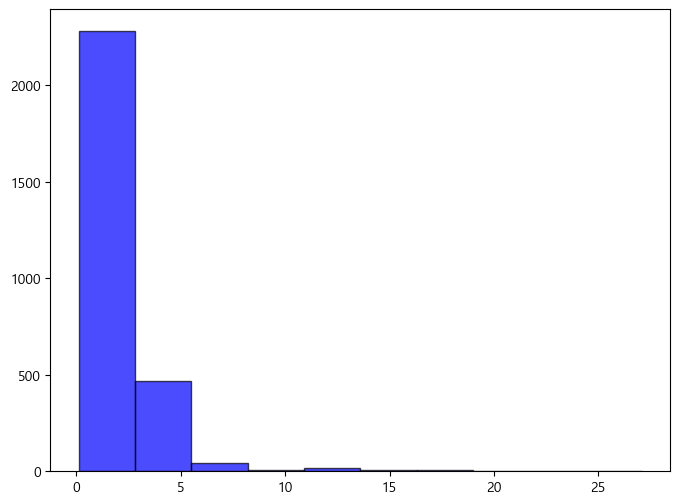

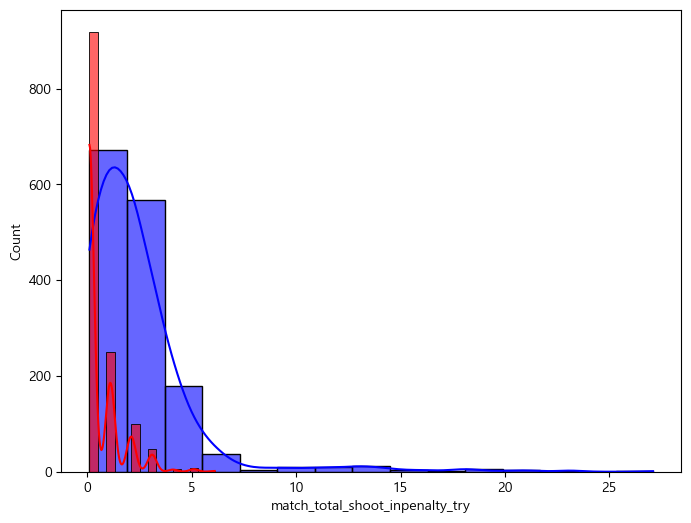

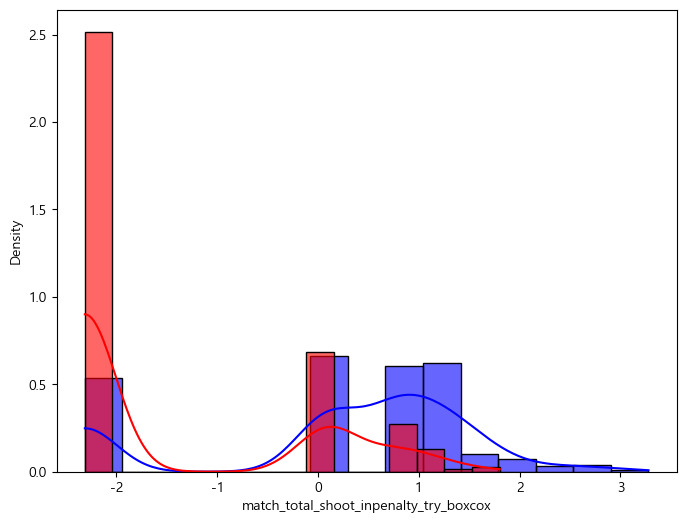

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))  

ax.hist(x, color='blue', alpha=0.7, edgecolor='black')

fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(x_win, color='blue', bins = 15, kde=True, ax=ax, label='승', alpha=0.6);
sns.histplot(x_lose, color='red', bins = 15, kde=True, ax=ax, label='패', alpha=0.6);

fig, ax = plt.subplots(figsize=(8, 6))

sns.histplot(y_win, color='blue', bins = 15, kde=True, ax=ax, label='승', stat="density", alpha=0.6);
sns.histplot(y_lose, color='red', bins = 15, kde=True, ax=ax, label='패', stat="density", alpha=0.6);

---

In [133]:
df3_position_temp = df3[['match_result'] + position_ratings_col].copy()

In [134]:
df3_position_temp = df3_position_temp[df3_position_temp['attack_position_ratings'] != 10]
df3_position_temp = df3_position_temp[df3_position_temp['middle_position_ratings'] != 10]
df3_position_temp = df3_position_temp[df3_position_temp['defense_position_ratings'] != 10]
df3_position_temp = df3_position_temp[df3_position_temp['goalkeeper_position_ratings'] != 10]

In [135]:
df3_position_temp_qq = df3_position_temp.copy()

In [136]:
df3_position_temp_win = df3_position_temp[df3_position_temp['match_result'] == '승']
df3_position_temp_lose = df3_position_temp[df3_position_temp['match_result'] == '패']

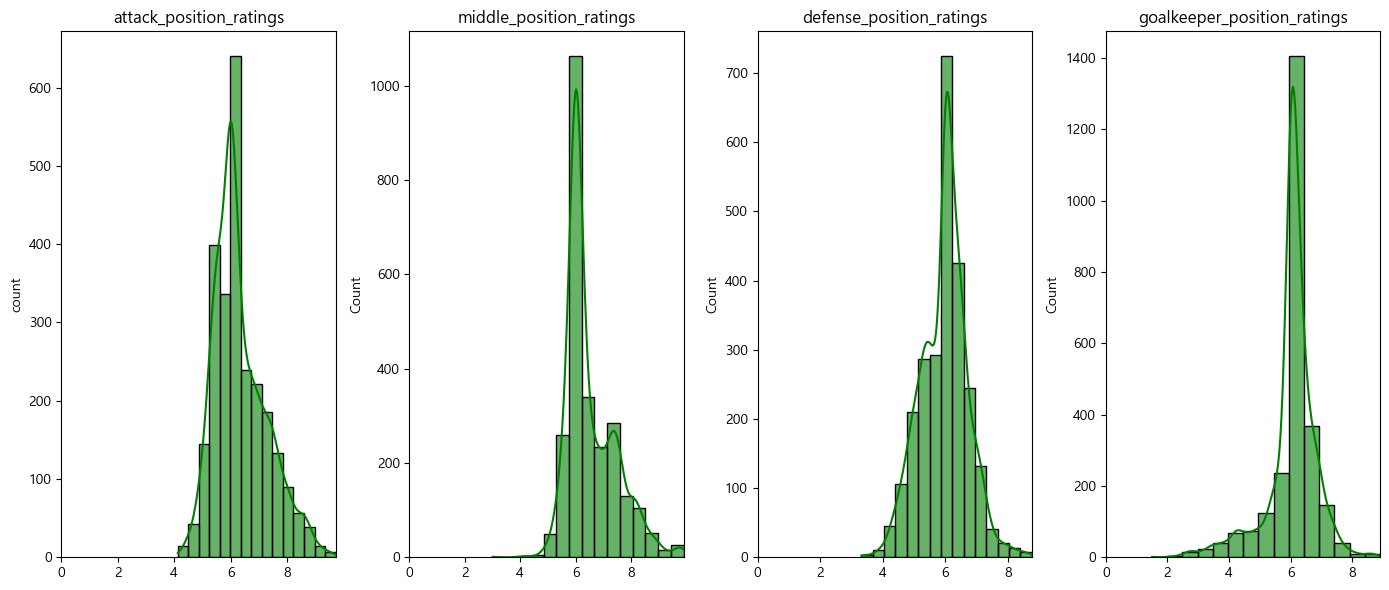

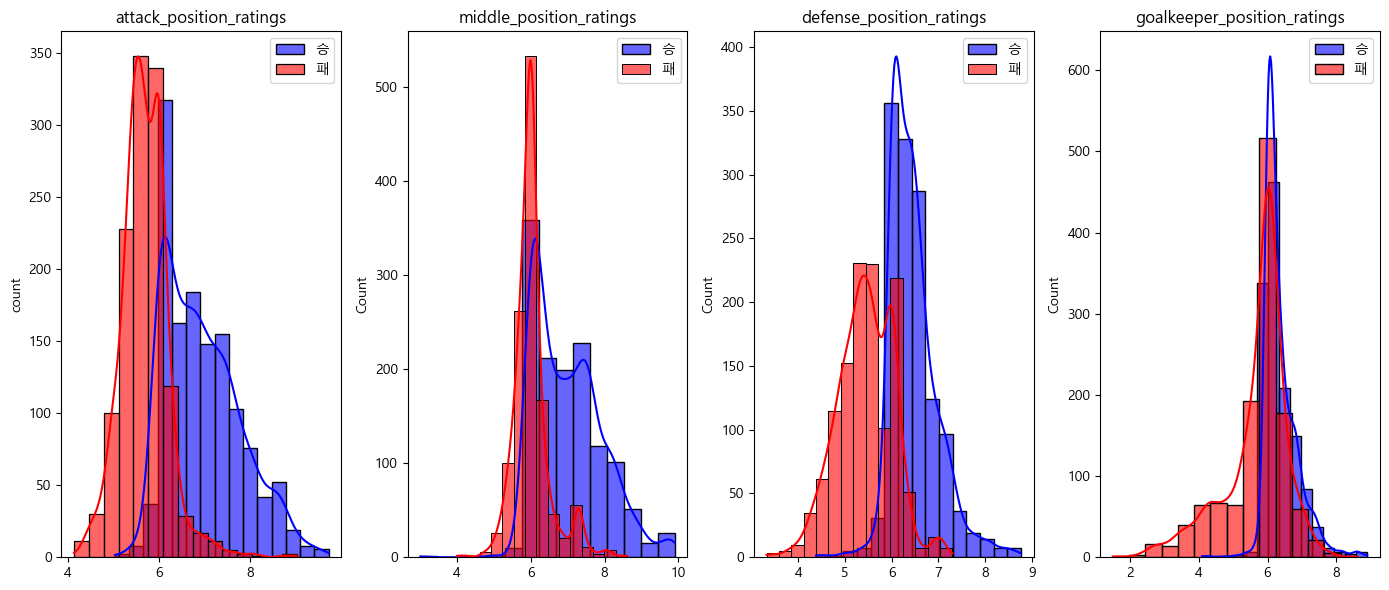

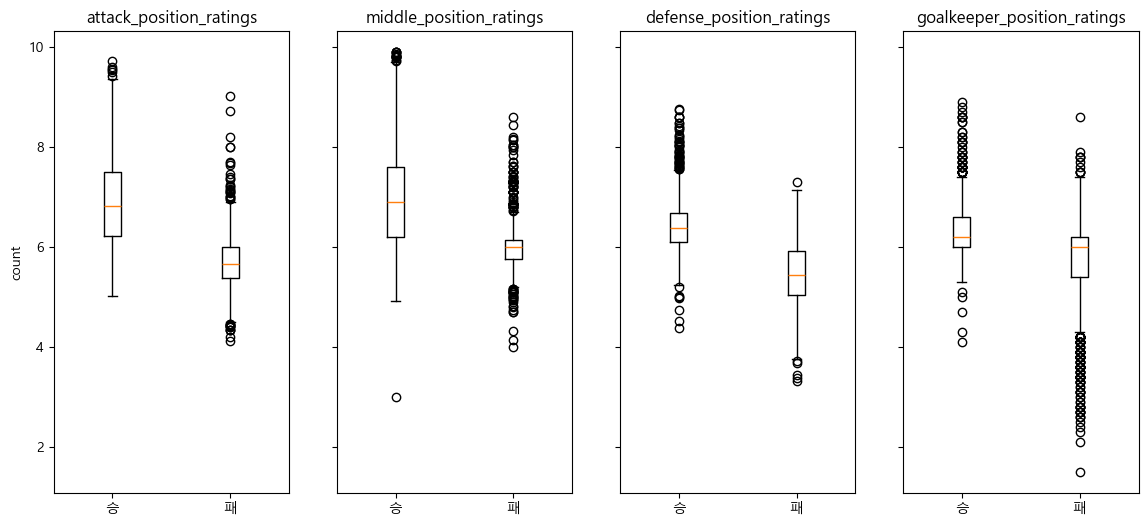

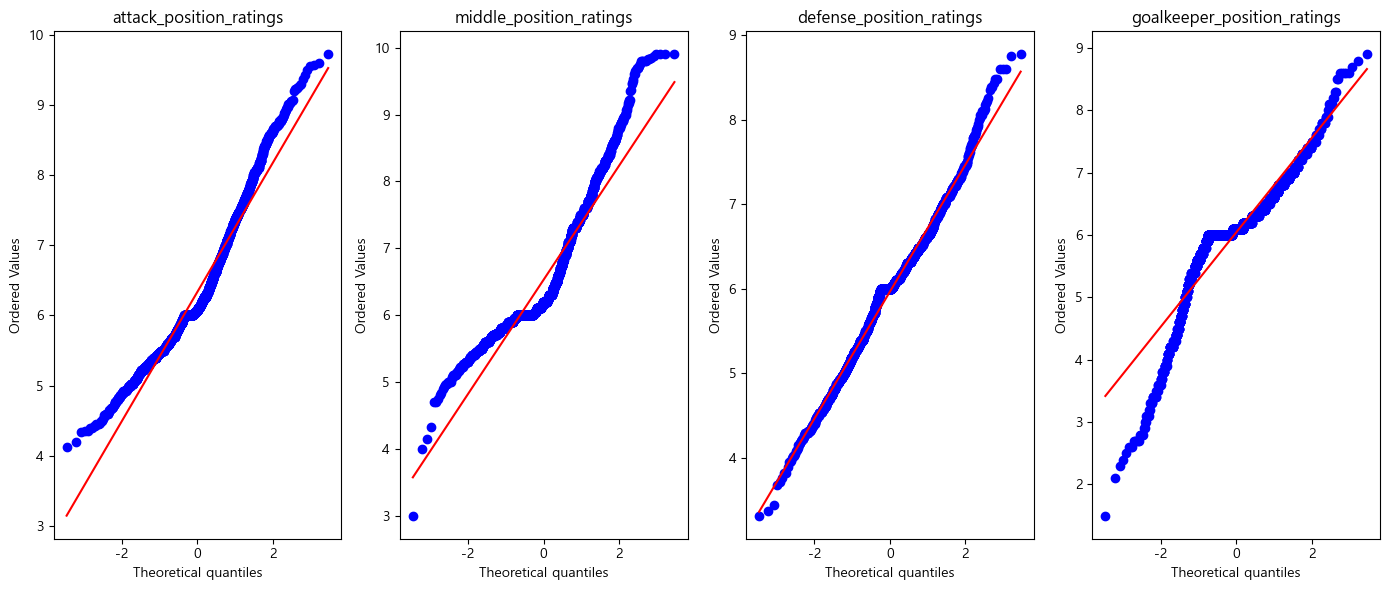

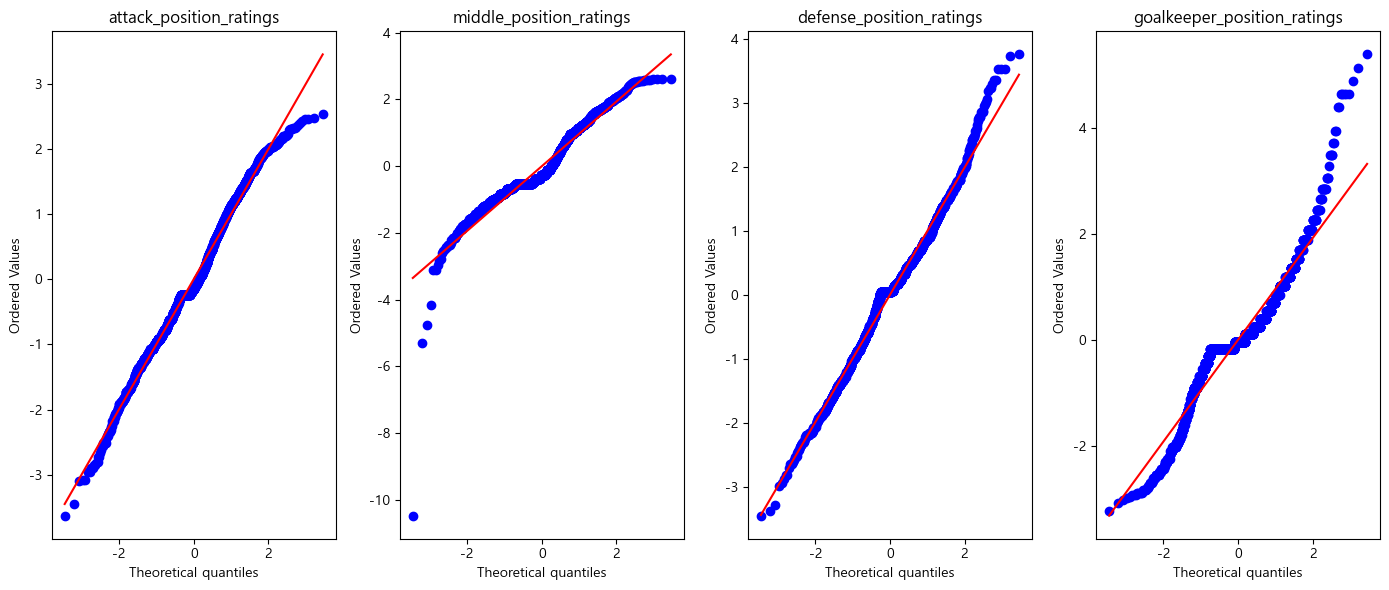

In [137]:
col_hist_all(df3_position_temp, position_ratings_col);
col_hist(df3_position_temp_win, df3_position_temp_lose, position_ratings_col);
col_boxplot(df3_position_temp_win, df3_position_temp_lose, position_ratings_col, True);
col_qqplot_all(df3_position_temp, position_ratings_col);
col_qqplot_norm_all(df3_position_temp_qq, position_ratings_col);

In [138]:
df3_position_temp_qq_win = df3_position_temp_qq[df3_position_temp_qq['match_result'] == '승']
df3_position_temp_qq_lose = df3_position_temp_qq[df3_position_temp_qq['match_result'] == '패']

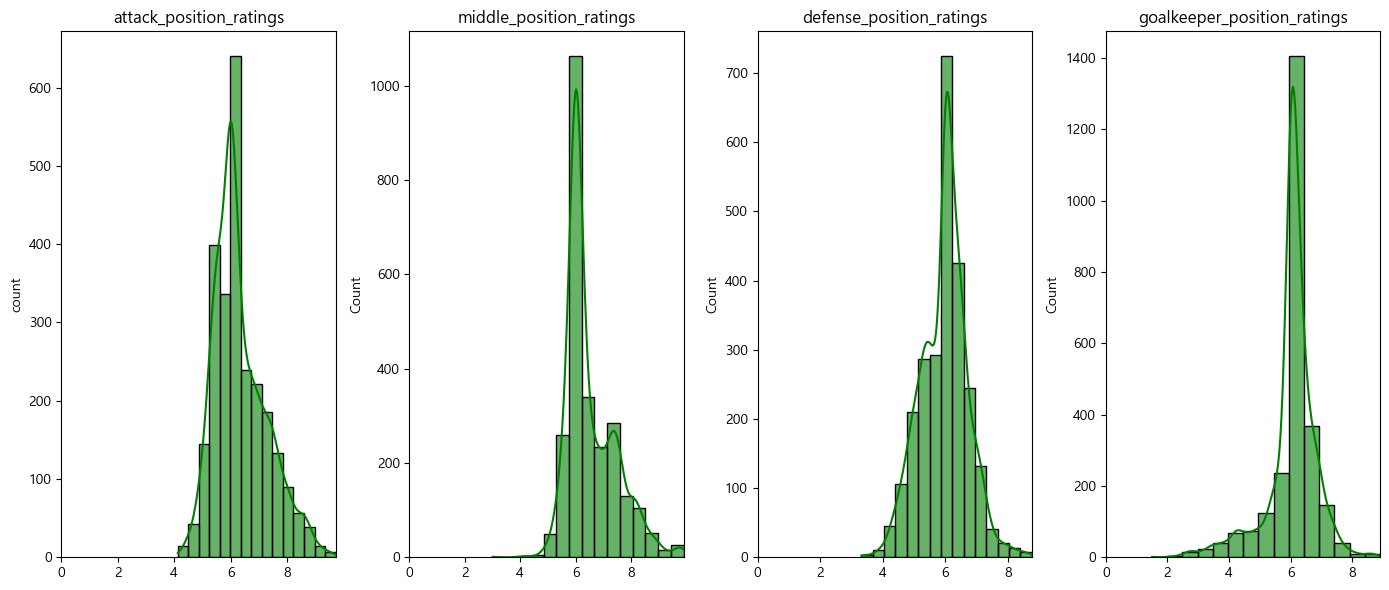

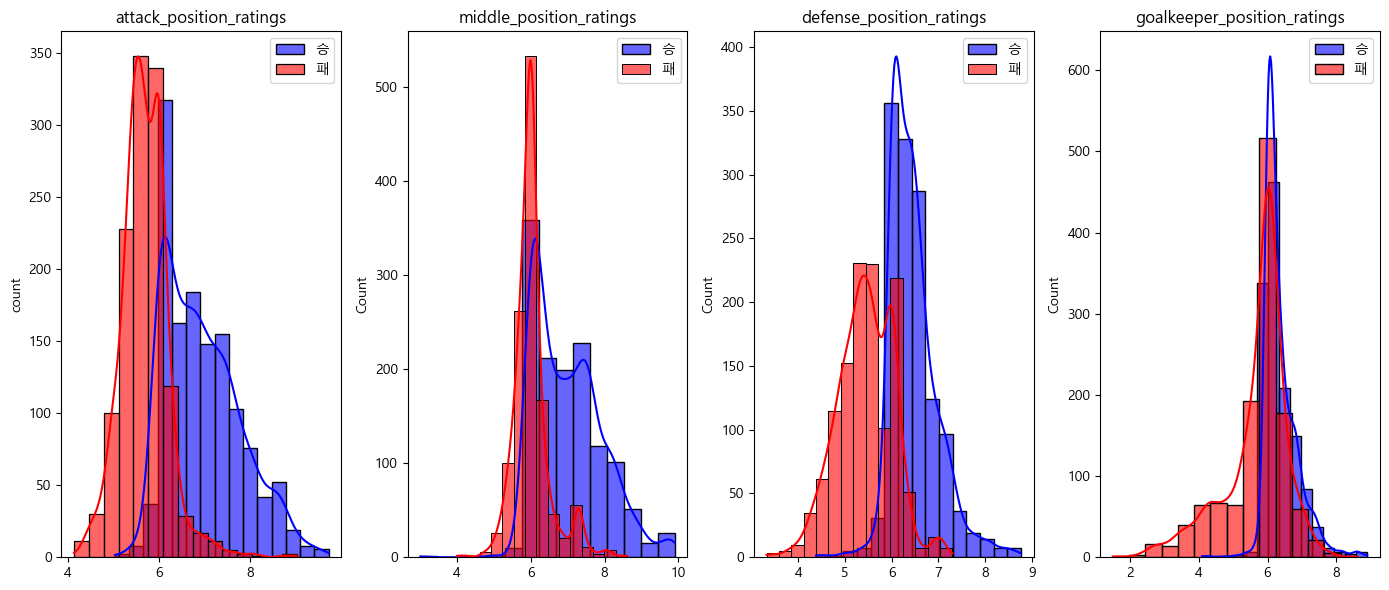

In [142]:
col_hist_all(df3_position_temp, position_ratings_col);
col_hist(df3_position_temp_win, df3_position_temp_lose, position_ratings_col);

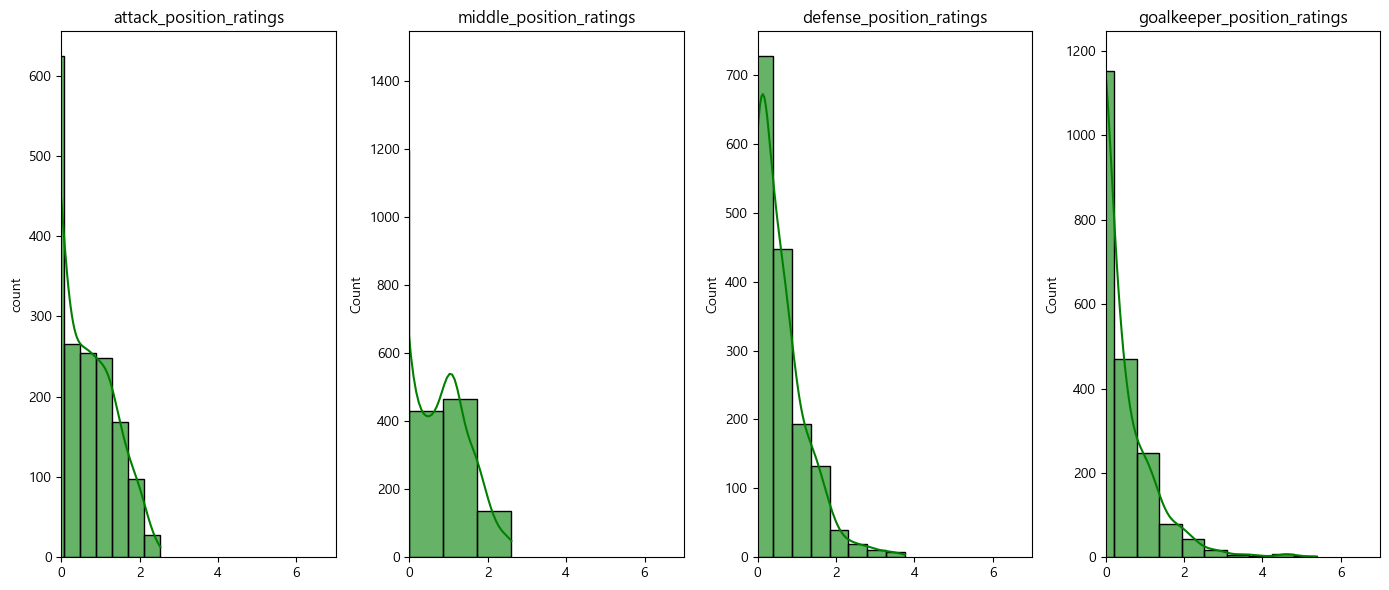

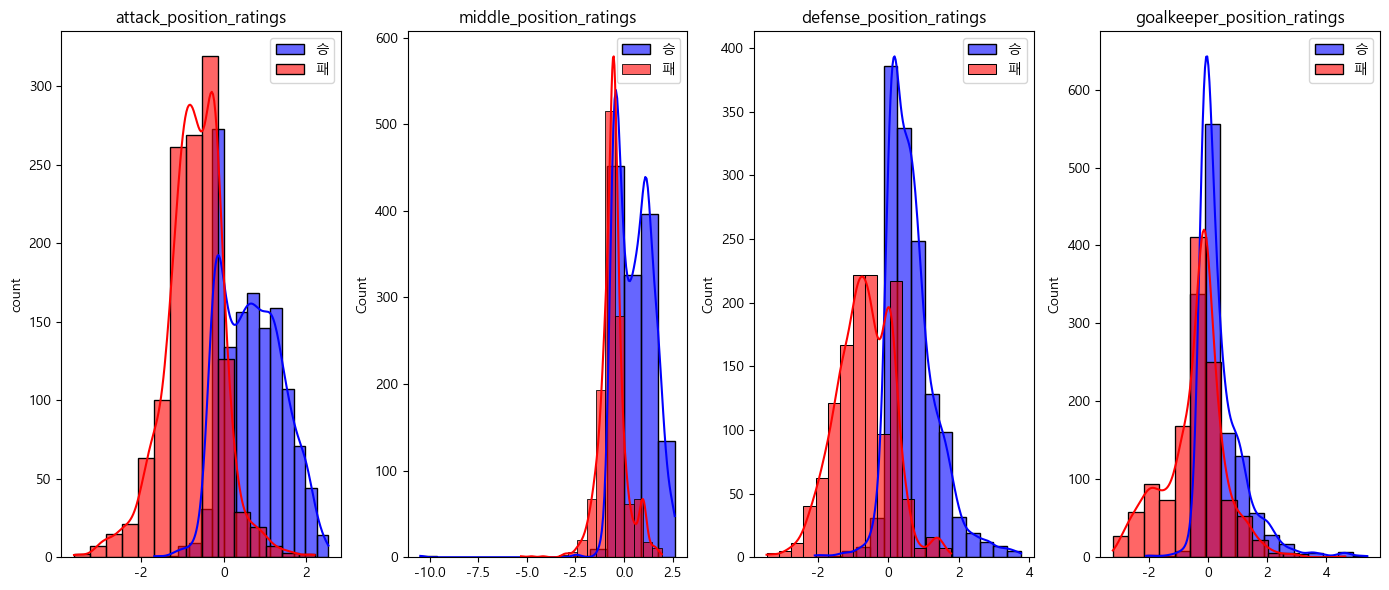

In [139]:
col_hist_all(df3_position_temp_qq, position_ratings_col);
col_hist(df3_position_temp_qq_win, df3_position_temp_qq_lose, position_ratings_col);

In [141]:
normality_test(df3_position_temp_win, df3_position_temp_lose, position_ratings_col)

attack_position_ratings 
 승: p-value=(2.779015395968604e-21, 4.018637369315889e-09)                       
 패: p-value=(1.170976428664024e-19, 6.744744358620897e-07)                       
 Levene’s test p-value=2.7809970904867556e-64
middle_position_ratings 
 승: p-value=(4.972674829823879e-24, 3.4884025857940325e-14)                       
 패: p-value=(5.114963007190142e-30, 3.96268071998687e-37)                       
 Levene’s test p-value=8.847980584628235e-113
defense_position_ratings 
 승: p-value=(3.017460847739262e-26, 2.094219461298858e-18)                       
 패: p-value=(1.8865756008367834e-07, 6.611621878220369e-05)                       
 Levene’s test p-value=3.2953285756175747e-10
goalkeeper_position_ratings 
 승: p-value=(2.443573851748739e-34, 9.020712999214966e-44)                       
 패: p-value=(3.7314025151496756e-28, 1.4031573410479406e-40)                       
 Levene’s test p-value=1.2158480815732963e-32
----------------------------------------------------

In [140]:
normality_test(df3_position_temp_qq_win, df3_position_temp_qq_lose, position_ratings_col)

attack_position_ratings 
 승: p-value=(3.823417749096195e-15, 4.069380587741458e-06)                       
 패: p-value=(1.1364816002355992e-13, 0.0002956723110489443)                       
 Levene’s test p-value=8.682348402672721e-07
middle_position_ratings 
 승: p-value=(1.6277782241423984e-27, 1.0500406019613864e-10)                       
 패: p-value=(4.896043935746978e-25, 1.7231384043306203e-22)                       
 Levene’s test p-value=2.380010404421132e-50
defense_position_ratings 
 승: p-value=(1.7586830480178728e-26, 1.5281133095701553e-18)                       
 패: p-value=(2.4207376831786177e-07, 6.486874846964313e-05)                       
 Levene’s test p-value=3.3182922646803644e-09
goalkeeper_position_ratings 
 승: p-value=(1.2374528540275727e-38, 1.127293664150749e-50)                       
 패: p-value=(3.9639578237195276e-19, 1.8056600170191988e-28)                       
 Levene’s test p-value=2.9000619550701555e-12
-----------------------------------------------

In [ ]:
df_temp_df = pd.read_csv()